# 应用PINN求解一维欧拉方程（Sod激波管问题）

In [1]:
# Import libraries
import torch
import torch.nn as nn
import numpy as np
import time
import scipy.io

# Seeds
torch.manual_seed(123)
np.random.seed(123)

In [2]:
# Train PINNs
def train_lbfgs(epoch):
    def closure():
        optimizer_lbfgs.zero_grad()                                                     # Optimizer
        loss_pde = model.loss_pde(x_int_train)                                    # Loss function of PDE
        loss_ic = model.loss_ic(x_ic_train, rho_ic_train,u_ic_train,p_ic_train)   # Loss function of IC
        loss = loss_pde + 10*loss_ic                                          # Total loss function G(theta)

        # Print iteration, loss of PDE and ICs
        print(f'epoch {epoch} loss_pde:{loss_pde:.8f}, loss_ic:{loss_ic:.8f}')
        loss.backward()
        return loss

    # Optimize loss function
    loss = optimizer_lbfgs.step(closure)
    loss_value = loss.item() if not isinstance(loss, float) else loss
    # Print total loss
    #print(f'epoch {epoch}: loss {loss_value:.6f}')
def train_adam(epoch):
    optimizer_adam.zero_grad()                                                     # Optimizer
    loss_pde = model.loss_pde(x_int_train)                                    # Loss function of PDE
    loss_ic = model.loss_ic(x_ic_train, rho_ic_train,u_ic_train,p_ic_train)   # Loss function of IC
    loss = loss_pde + 10*loss_ic                                          # Total loss function G(theta)
    
    print(f'epoch {epoch} loss_pde:{loss_pde:.8f}, loss_ic:{loss_ic:.8f}')
    loss.backward()
    loss = optimizer_adam.step()
    # Print total loss
    #print(f'epoch {epoch}: loss {loss_value:.6f}')
   
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,grad_outputs=torch.ones_like(outputs), create_graph=True)

# Convert torch tensor into np.array
def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or ' \
                        'np.ndarray, but got {}'.format(type(input)))

# Initial conditions
def IC(x):
    N = len(x)
    rho_init = np.zeros((x.shape[0]))                                              # rho - initial condition
    u_init = np.zeros((x.shape[0]))                                                # u - initial condition
    p_init = np.zeros((x.shape[0]))                                                # p - initial condition

    # rho, p - initial condition
    for i in range(N):
        if (x[i] <= 0.5):
            rho_init[i] = 1.0
            p_init[i] = 1.0
        else:
            rho_init[i] = 0.125
            p_init[i] = 0.1

    return rho_init, u_init, p_init

In [3]:
# Generate Neural Network
class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential()                                                  # Define neural network
        self.net.add_module('Linear_layer_1', nn.Linear(2, 30))                     # First linear layer
        self.net.add_module('Tanh_layer_1', nn.Tanh())                              # First activation Layer

        for num in range(2, 5):                                                     # Number of layers (2 through 7)
            self.net.add_module('Linear_layer_%d' % (num), nn.Linear(30, 30))       # Linear layer
            self.net.add_module('Tanh_layer_%d' % (num), nn.Tanh())                 # Activation Layer
        self.net.add_module('Linear_layer_final', nn.Linear(30, 3))                 # Output Layer
        self.iter = 0
    # Forward Feed
    def forward(self, x):
        return self.net(x)
    
    def optimizer_lbfgs(self,lr):
        return torch.optim.LBFGS(
               self.net.parameters(),
               lr=lr,
               max_iter=20,
               max_eval=None,
               tolerance_grad=1e-06,
               #tolerance_change=1.finfo(float).eps,
               tolerance_change=1e-9,
               history_size=100,
               line_search_fn="strong_wolfe",)
    def optimizer_adam(self,lr):
        return torch.optim.Adam(self.net.parameters(), lr=lr)
    
    # Loss function for PDE
    def loss_pde(self, x):
        y = self.net(x)                                                # Neural network
        rho,p,u = y[:, 0:1], y[:, 1:2], y[:, 2:]
        
        U2 = rho*u
        U3 = 0.5*rho*u**2 + p/0.4
        
        #F1 = U2
        F2 = rho*u**2+p
        F3 = u*(U3 + p)
        epsilon = 1e-5
        s = torch.log((abs(p)+p+epsilon)/2/((abs(rho)+rho)/2+epsilon)**1.4)
        eta = -rho*s/0.4
        phi = -rho*u*s/0.4
        
        # NN_{rho}, NN_{u}, NN_{p}
        gamma = 1.4                                                    # Heat Capacity Ratio

        # Gradients and partial derivatives
        drho_g = gradients(rho, x)[0]                                  # Gradient [rho_t, rho_x]
        rho_t, rho_x = drho_g[:, :1], drho_g[:, 1:]                    # Partial derivatives rho_t, rho_x


        du_g = gradients(u, x)[0]                                      # Gradient [u_t, u_x]
        u_t, u_x = du_g[:, :1], du_g[:, 1:]                            # Partial derivatives u_t, u_x


        dp_g = gradients(p, x)[0]                                      # Gradient [p_t, p_x]
        p_t, p_x = dp_g[:, :1], dp_g[:, 1:]                            # Partial derivatives p_t, p_x
        
        deta_g = gradients(eta, x)[0]                                      # Gradient [p_t, p_x]
        eta_t, eta_x = deta_g[:, :1], deta_g[:, 1:]                            # Partial derivatives p_t, p_x
        dphi_g = gradients(phi, x)[0]                                      # Gradient [p_t, p_x]
        phi_t, phi_x = dphi_g[:, :1], dphi_g[:, 1:]                            # Partial derivatives p_t, p_x

        dU2_g = gradients(U2, x)[0]
        U2_t,U2_x = dU2_g[:,:1], dU2_g[:,1:]
        dU3_g = gradients(U3, x)[0]
        U3_t,U3_x = dU3_g[:,:1], dU3_g[:,1:]
        dF2_g = gradients(F2, x)[0]
        F2_t,F2_x = dF2_g[:,:1], dF2_g[:,1:]
        dF3_g = gradients(F3, x)[0]
        F3_t,F3_x = dF3_g[:,:1], dF3_g[:,1:]


        # Loss function for the Euler Equations
       # f = ((rho_t + u*rho_x + rho*u_x)**2).mean() + \
       #     ((rho*(u_t + (u)*u_x) + (p_x))**2).mean() + \
       #     ((p_t + gamma*p*u_x + u*p_x)**2).mean()
            #((U2_t  + F2_x)**2).mean() 
        f = (((rho_t + U2_x)/(0.1*(abs(u_x)-u_x)  + 1))**2).mean() + \
            (((U2_t  + F2_x)/(0.1*(abs(u_x)-u_x)  + 1))**2).mean() + \
            (((U3_t  + F3_x)/(0.1*(abs(u_x)-u_x)  + 1))**2).mean()# + \
           # 0.1*((abs(eta_t+phi_x)+eta_t+phi_x)).mean()   + \
           # (abs(rho_t)).mean() + (abs(U3_t)).mean() # 
        #f = (((rho_t + U2_x))**2).mean() + \
        #    (((U2_t  + F2_x))**2).mean() + \
        #    (((U3_t  + F3_x))**2).mean()# + \
         #   (abs(rho_t)).mean() + (abs(U3_t)).mean() # 
            #0.1*((abs(eta_t+phi_x)+eta_t+phi_x)).mean() 
            #((abs(rho)-rho)**2).mean() + 0.1*((abs(U3) - U3)**2).mean() 
          #  ((min(rho,0))**2).mean() + 0.1*((min(U3,0))**2).mean() +\
            

       # f = (((rho_t + U2_x))**2).mean() + \
       #     (((U2_t  + F2_x))**2).mean() + \
       #     (((U3_t  + F3_x))**2).mean() + \ 
       #     0.1*((abs(eta_t+phi_x)+eta_t+phi_x)).mean() 
       #     ((rho*(u_t + (u)*u_x) + (p_x))**2).mean() + \
       #     ((p_t + gamma*p*u_x + u*p_x)**2).mean()
          #  ((U3_t  + F3_x)**2).mean()

        return f

    # Loss function for initial condition
    def loss_ic(self, x_ic, rho_ic, u_ic, p_ic):
        y_ic = self.net(x_ic)                                                      # Initial condition
        rho_ic_nn, p_ic_nn,u_ic_nn = y_ic[:, 0], y_ic[:, 1], y_ic[:, 2]            # rho, u, p - initial condition

        # Loss function for the initial condition
        loss_ics = ((u_ic_nn - u_ic) ** 2).mean() + \
               ((rho_ic_nn- rho_ic) ** 2).mean()  + \
               ((p_ic_nn - p_ic) ** 2).mean()

        return loss_ics

In [4]:
device = torch.device('cuda')         # change to cpu if you dont have a cuda device                              
num_x = 100                                                        
num_t = 200                                                        
num_i_train = 1000                                                 
num_f_train = 10000                                                
x = np.linspace(0.0, 1.0, num_x)                                   
t = np.linspace(0, 0.2, num_t)                                     
t_grid, x_grid = np.meshgrid(t, x)                                 
T = t_grid.flatten()[:, None]                                      
X = x_grid.flatten()[:, None]                                      
id_f = np.random.choice(num_x*num_t, num_f_train, replace=False)   

x_int = X[:, 0][id_f, None]                                        
t_int = T[:, 0][id_f, None]                                        
x_int_train = np.hstack((t_int, x_int))                            

x = np.linspace(0.0, 1.0, 1000)                                   
t = np.linspace(0, 0.2, 100)                                       
t_grid, x_grid = np.meshgrid(t, x)                                 
id_ic = np.random.choice(1000, 1000, replace=False)   
T = t_grid.flatten()[:, None]                                      
X = x_grid.flatten()[:, None]                                      
x_ic = x_grid[id_ic, 0][:, None]                                   
t_ic = t_grid[id_ic, 0][:, None]                                   
x_ic_train = np.hstack((t_ic, x_ic))

rho_ic_train, u_ic_train, p_ic_train = IC(x_ic)                    
x = np.linspace(0.0, 1.0, 100)                                   # Partitioned spatial axis
t = np.linspace(0, 0.2, 20)                                        # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)                                    # (t,x) in [0,0.2]x[a,b]
id_ic = np.random.choice(100, 100, replace=False)           # Random sample numbering for IC
T = t_grid.flatten()[:, None]                                         # Vectorized t_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
x_ic = x_grid[id_ic, 0][:, None]                                      # Random x - initial condition
t_ic = t_grid[id_ic, 0][:, None]                                      # random t - initial condition
x_ic2 = np.hstack((t_ic, x_ic))                                  # Random (x,t) - vectorized

#x_end = X_entropy(x_ic2,0.2)                                 # Random (x,t) - vectorized
#x_r = X_right(x_end,0.01)                                 # Random (x,t) - vectorized

#x_end2 = X_entropy(x_ic_train,0.2)                                 # Random (x,t) - vectorized

#x_end       = torch.tensor(x_end, dtype=torch.float32).to(device)
#x_end2       = torch.tensor(x_end2, dtype=torch.float32).to(device)
#x_r         = torch.tensor(x_r, dtype=torch.float32).to(device)

x_ic_train = torch.tensor(x_ic_train, dtype=torch.float32).to(device)
x_int_train = torch.tensor(x_int_train, requires_grad=True, dtype=torch.float32).to(device)

rho_ic_train = torch.tensor(rho_ic_train, dtype=torch.float32).to(device)
u_ic_train = torch.tensor(u_ic_train, dtype=torch.float32).to(device)
p_ic_train = torch.tensor(p_ic_train, dtype=torch.float32).to(device)

model = DNN().to(device)

print('Start training...')

RuntimeError: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW

In [20]:
optimizer_lbfgs= torch.optim.LBFGS(
               model.net.parameters(),
               lr=0.1,
               max_iter=20,
               max_eval=None,
               tolerance_grad=1e-06,
               #tolerance_change=1.finfo(float).eps,
               tolerance_change=1e-9,
               history_size=100,
               line_search_fn="strong_wolfe",)
optimizer_adam = torch.optim.Adam(model.net.parameters(), lr=0.001)

In [25]:
#epochs = 20
tic = time.time()
for epoch in range(1,100):
    train_adam(epoch)
    
for epoch in range(1, 3000):
    train_lbfgs(epoch)




epoch 1 loss_pde:0.00489207, loss_ic:0.00003916
epoch 2 loss_pde:0.01271120, loss_ic:0.00004937
epoch 3 loss_pde:26.57295990, loss_ic:0.00111208
epoch 4 loss_pde:2.17690706, loss_ic:0.00086963
epoch 5 loss_pde:51.45713806, loss_ic:0.00445937
epoch 6 loss_pde:11.22716331, loss_ic:0.00847994
epoch 7 loss_pde:19.02653503, loss_ic:0.01342925
epoch 8 loss_pde:103.36899567, loss_ic:0.02079128
epoch 9 loss_pde:20.97176933, loss_ic:0.02227352
epoch 10 loss_pde:222.14784241, loss_ic:0.02241548
epoch 11 loss_pde:10.38277435, loss_ic:0.03002389
epoch 12 loss_pde:46.83317184, loss_ic:0.03679582
epoch 13 loss_pde:117.50974274, loss_ic:0.04542503
epoch 14 loss_pde:39.42586517, loss_ic:0.05317060
epoch 15 loss_pde:308.98852539, loss_ic:0.05969805
epoch 16 loss_pde:16.92804527, loss_ic:0.06449632
epoch 17 loss_pde:42.23954010, loss_ic:0.07028919
epoch 18 loss_pde:8.24898624, loss_ic:0.07835522
epoch 19 loss_pde:24.99424362, loss_ic:0.08576377
epoch 20 loss_pde:56.75336838, loss_ic:0.09345620
epoch 21 

epoch 3 loss_pde:0.13402075, loss_ic:0.00834475
epoch 3 loss_pde:0.13047259, loss_ic:0.00831977
epoch 3 loss_pde:0.12941788, loss_ic:0.00830961
epoch 3 loss_pde:0.12528083, loss_ic:0.00827708
epoch 4 loss_pde:0.12528083, loss_ic:0.00827708
epoch 4 loss_pde:0.12329747, loss_ic:0.00825466
epoch 4 loss_pde:0.11613631, loss_ic:0.00817832
epoch 4 loss_pde:0.11462610, loss_ic:0.00813578
epoch 4 loss_pde:0.10945988, loss_ic:0.00798915
epoch 4 loss_pde:0.10848130, loss_ic:0.00796209
epoch 4 loss_pde:0.10376154, loss_ic:0.00778761
epoch 4 loss_pde:0.10331232, loss_ic:0.00775288
epoch 4 loss_pde:0.10216714, loss_ic:0.00760162
epoch 4 loss_pde:0.10174824, loss_ic:0.00754393
epoch 4 loss_pde:0.10016146, loss_ic:0.00708140
epoch 4 loss_pde:0.09980810, loss_ic:0.00701735
epoch 4 loss_pde:0.09915967, loss_ic:0.00649019
epoch 4 loss_pde:0.09906347, loss_ic:0.00641505
epoch 4 loss_pde:0.10012541, loss_ic:0.00575050
epoch 4 loss_pde:0.10028261, loss_ic:0.00560730
epoch 4 loss_pde:0.10772949, loss_ic:0.0

epoch 10 loss_pde:0.04276018, loss_ic:0.00030287
epoch 10 loss_pde:0.04232691, loss_ic:0.00031388
epoch 10 loss_pde:0.04225775, loss_ic:0.00031468
epoch 10 loss_pde:0.04199297, loss_ic:0.00031933
epoch 10 loss_pde:0.04195565, loss_ic:0.00031734
epoch 10 loss_pde:0.04182390, loss_ic:0.00030908
epoch 10 loss_pde:0.04177937, loss_ic:0.00030570
epoch 10 loss_pde:0.04167602, loss_ic:0.00029588
epoch 11 loss_pde:0.04167602, loss_ic:0.00029588
epoch 11 loss_pde:0.04161959, loss_ic:0.00028978
epoch 11 loss_pde:0.04157209, loss_ic:0.00028216
epoch 11 loss_pde:0.04151740, loss_ic:0.00027079
epoch 11 loss_pde:0.04147685, loss_ic:0.00026331
epoch 11 loss_pde:0.04140609, loss_ic:0.00023285
epoch 11 loss_pde:0.04137749, loss_ic:0.00023003
epoch 11 loss_pde:0.04134901, loss_ic:0.00022462
epoch 11 loss_pde:0.04120921, loss_ic:0.00022543
epoch 11 loss_pde:0.04115139, loss_ic:0.00022148
epoch 11 loss_pde:0.04096750, loss_ic:0.00020422
epoch 11 loss_pde:0.04085990, loss_ic:0.00020408
epoch 11 loss_pde:0.

epoch 17 loss_pde:0.02690349, loss_ic:0.00015354
epoch 17 loss_pde:0.02688390, loss_ic:0.00015149
epoch 17 loss_pde:0.02688098, loss_ic:0.00015123
epoch 17 loss_pde:0.02687114, loss_ic:0.00015015
epoch 17 loss_pde:0.02686821, loss_ic:0.00014993
epoch 17 loss_pde:0.02686280, loss_ic:0.00014941
epoch 17 loss_pde:0.02685740, loss_ic:0.00014908
epoch 17 loss_pde:0.02683840, loss_ic:0.00014772
epoch 17 loss_pde:0.02682991, loss_ic:0.00014736
epoch 17 loss_pde:0.02680932, loss_ic:0.00014636
epoch 17 loss_pde:0.02679331, loss_ic:0.00014592
epoch 17 loss_pde:0.02677145, loss_ic:0.00014529
epoch 17 loss_pde:0.02674237, loss_ic:0.00014474
epoch 17 loss_pde:0.02669098, loss_ic:0.00014377
epoch 17 loss_pde:0.02665048, loss_ic:0.00014362
epoch 18 loss_pde:0.02665048, loss_ic:0.00014362
epoch 18 loss_pde:0.02660416, loss_ic:0.00014354
epoch 18 loss_pde:0.02645578, loss_ic:0.00014411
epoch 18 loss_pde:0.02642322, loss_ic:0.00014455
epoch 18 loss_pde:0.02639108, loss_ic:0.00014484
epoch 18 loss_pde:0.

epoch 24 loss_pde:0.02081114, loss_ic:0.00006130
epoch 24 loss_pde:0.02071868, loss_ic:0.00006481
epoch 24 loss_pde:0.02069552, loss_ic:0.00006574
epoch 24 loss_pde:0.02064467, loss_ic:0.00006808
epoch 24 loss_pde:0.02062181, loss_ic:0.00006903
epoch 24 loss_pde:0.02055537, loss_ic:0.00007224
epoch 24 loss_pde:0.02053421, loss_ic:0.00007318
epoch 24 loss_pde:0.02047565, loss_ic:0.00007619
epoch 24 loss_pde:0.02045880, loss_ic:0.00007687
epoch 24 loss_pde:0.02042548, loss_ic:0.00007838
epoch 24 loss_pde:0.02040856, loss_ic:0.00007894
epoch 24 loss_pde:0.02036996, loss_ic:0.00008040
epoch 24 loss_pde:0.02035535, loss_ic:0.00008072
epoch 24 loss_pde:0.02029824, loss_ic:0.00008236
epoch 24 loss_pde:0.02028858, loss_ic:0.00008198
epoch 24 loss_pde:0.02028095, loss_ic:0.00008164
epoch 24 loss_pde:0.02026922, loss_ic:0.00008103
epoch 24 loss_pde:0.02025142, loss_ic:0.00008087
epoch 24 loss_pde:0.02018617, loss_ic:0.00008044
epoch 24 loss_pde:0.02017627, loss_ic:0.00007961
epoch 24 loss_pde:0.

epoch 30 loss_pde:0.01659997, loss_ic:0.00006349
epoch 30 loss_pde:0.01659756, loss_ic:0.00006304
epoch 30 loss_pde:0.01659055, loss_ic:0.00006119
epoch 30 loss_pde:0.01658765, loss_ic:0.00006102
epoch 30 loss_pde:0.01658588, loss_ic:0.00006086
epoch 31 loss_pde:0.01658588, loss_ic:0.00006086
epoch 31 loss_pde:0.01658193, loss_ic:0.00006066
epoch 31 loss_pde:0.01657161, loss_ic:0.00006002
epoch 31 loss_pde:0.01656798, loss_ic:0.00005994
epoch 31 loss_pde:0.01655977, loss_ic:0.00005974
epoch 31 loss_pde:0.01655554, loss_ic:0.00005973
epoch 31 loss_pde:0.01653985, loss_ic:0.00005975
epoch 31 loss_pde:0.01653562, loss_ic:0.00005982
epoch 31 loss_pde:0.01651914, loss_ic:0.00006022
epoch 31 loss_pde:0.01651268, loss_ic:0.00006038
epoch 31 loss_pde:0.01650136, loss_ic:0.00006069
epoch 31 loss_pde:0.01648906, loss_ic:0.00006095
epoch 31 loss_pde:0.01644043, loss_ic:0.00006225
epoch 31 loss_pde:0.01643045, loss_ic:0.00006244
epoch 31 loss_pde:0.01641814, loss_ic:0.00006272
epoch 31 loss_pde:0.

epoch 37 loss_pde:0.01392794, loss_ic:0.00004126
epoch 37 loss_pde:0.01391981, loss_ic:0.00004121
epoch 37 loss_pde:0.01389253, loss_ic:0.00004103
epoch 37 loss_pde:0.01388917, loss_ic:0.00004066
epoch 37 loss_pde:0.01388401, loss_ic:0.00004035
epoch 37 loss_pde:0.01386882, loss_ic:0.00003903
epoch 37 loss_pde:0.01386416, loss_ic:0.00003897
epoch 37 loss_pde:0.01384371, loss_ic:0.00003861
epoch 37 loss_pde:0.01383975, loss_ic:0.00003867
epoch 37 loss_pde:0.01383320, loss_ic:0.00003878
epoch 37 loss_pde:0.01382542, loss_ic:0.00003899
epoch 37 loss_pde:0.01379466, loss_ic:0.00004008
epoch 37 loss_pde:0.01378795, loss_ic:0.00004029
epoch 37 loss_pde:0.01376235, loss_ic:0.00004127
epoch 37 loss_pde:0.01375716, loss_ic:0.00004145
epoch 37 loss_pde:0.01375305, loss_ic:0.00004161
epoch 38 loss_pde:0.01375305, loss_ic:0.00004161
epoch 38 loss_pde:0.01374571, loss_ic:0.00004181
epoch 38 loss_pde:0.01373480, loss_ic:0.00004214
epoch 38 loss_pde:0.01372627, loss_ic:0.00004201
epoch 38 loss_pde:0.

epoch 44 loss_pde:0.01230756, loss_ic:0.00002752
epoch 44 loss_pde:0.01229927, loss_ic:0.00002775
epoch 44 loss_pde:0.01229757, loss_ic:0.00002775
epoch 44 loss_pde:0.01229025, loss_ic:0.00002777
epoch 44 loss_pde:0.01228476, loss_ic:0.00002788
epoch 44 loss_pde:0.01227693, loss_ic:0.00002805
epoch 44 loss_pde:0.01227038, loss_ic:0.00002810
epoch 44 loss_pde:0.01224622, loss_ic:0.00002844
epoch 44 loss_pde:0.01223989, loss_ic:0.00002865
epoch 44 loss_pde:0.01223389, loss_ic:0.00002879
epoch 44 loss_pde:0.01221191, loss_ic:0.00002947
epoch 44 loss_pde:0.01220485, loss_ic:0.00002974
epoch 44 loss_pde:0.01220003, loss_ic:0.00002985
epoch 44 loss_pde:0.01218199, loss_ic:0.00003039
epoch 44 loss_pde:0.01217477, loss_ic:0.00003076
epoch 44 loss_pde:0.01217054, loss_ic:0.00003071
epoch 44 loss_pde:0.01216437, loss_ic:0.00003065
epoch 44 loss_pde:0.01215747, loss_ic:0.00003080
epoch 45 loss_pde:0.01215747, loss_ic:0.00003080
epoch 45 loss_pde:0.01215202, loss_ic:0.00003057
epoch 45 loss_pde:0.

epoch 51 loss_pde:0.01114667, loss_ic:0.00002416
epoch 51 loss_pde:0.01113169, loss_ic:0.00002437
epoch 51 loss_pde:0.01113027, loss_ic:0.00002433
epoch 51 loss_pde:0.01112790, loss_ic:0.00002425
epoch 51 loss_pde:0.01112591, loss_ic:0.00002420
epoch 51 loss_pde:0.01111882, loss_ic:0.00002397
epoch 51 loss_pde:0.01111740, loss_ic:0.00002386
epoch 51 loss_pde:0.01111652, loss_ic:0.00002377
epoch 51 loss_pde:0.01111461, loss_ic:0.00002367
epoch 51 loss_pde:0.01110992, loss_ic:0.00002333
epoch 51 loss_pde:0.01110872, loss_ic:0.00002318
epoch 51 loss_pde:0.01110809, loss_ic:0.00002304
epoch 51 loss_pde:0.01110640, loss_ic:0.00002290
epoch 51 loss_pde:0.01110145, loss_ic:0.00002228
epoch 51 loss_pde:0.01110103, loss_ic:0.00002212
epoch 51 loss_pde:0.01110107, loss_ic:0.00002191
epoch 51 loss_pde:0.01110044, loss_ic:0.00002175
epoch 51 loss_pde:0.01109879, loss_ic:0.00002105
epoch 52 loss_pde:0.01109879, loss_ic:0.00002105
epoch 52 loss_pde:0.01109816, loss_ic:0.00002092
epoch 52 loss_pde:0.

epoch 58 loss_pde:0.01023076, loss_ic:0.00001840
epoch 58 loss_pde:0.01022179, loss_ic:0.00001846
epoch 58 loss_pde:0.01021912, loss_ic:0.00001851
epoch 58 loss_pde:0.01020809, loss_ic:0.00001874
epoch 58 loss_pde:0.01020518, loss_ic:0.00001875
epoch 58 loss_pde:0.01019966, loss_ic:0.00001880
epoch 58 loss_pde:0.01019629, loss_ic:0.00001878
epoch 58 loss_pde:0.01018448, loss_ic:0.00001876
epoch 58 loss_pde:0.01018236, loss_ic:0.00001874
epoch 58 loss_pde:0.01017971, loss_ic:0.00001871
epoch 58 loss_pde:0.01017036, loss_ic:0.00001861
epoch 58 loss_pde:0.01016912, loss_ic:0.00001857
epoch 58 loss_pde:0.01016679, loss_ic:0.00001846
epoch 58 loss_pde:0.01016555, loss_ic:0.00001839
epoch 58 loss_pde:0.01016119, loss_ic:0.00001810
epoch 58 loss_pde:0.01016039, loss_ic:0.00001802
epoch 58 loss_pde:0.01015805, loss_ic:0.00001767
epoch 58 loss_pde:0.01015658, loss_ic:0.00001765
epoch 58 loss_pde:0.01015137, loss_ic:0.00001758
epoch 59 loss_pde:0.01015137, loss_ic:0.00001758
epoch 59 loss_pde:0.

epoch 65 loss_pde:0.00944751, loss_ic:0.00001696
epoch 65 loss_pde:0.00944357, loss_ic:0.00001711
epoch 65 loss_pde:0.00942748, loss_ic:0.00001786
epoch 65 loss_pde:0.00942491, loss_ic:0.00001793
epoch 65 loss_pde:0.00941974, loss_ic:0.00001812
epoch 65 loss_pde:0.00941621, loss_ic:0.00001820
epoch 65 loss_pde:0.00941372, loss_ic:0.00001827
epoch 65 loss_pde:0.00941014, loss_ic:0.00001831
epoch 65 loss_pde:0.00940639, loss_ic:0.00001837
epoch 65 loss_pde:0.00940401, loss_ic:0.00001823
epoch 65 loss_pde:0.00940099, loss_ic:0.00001821
epoch 65 loss_pde:0.00939827, loss_ic:0.00001819
epoch 65 loss_pde:0.00939358, loss_ic:0.00001827
epoch 65 loss_pde:0.00938990, loss_ic:0.00001815
epoch 65 loss_pde:0.00938404, loss_ic:0.00001791
epoch 65 loss_pde:0.00937767, loss_ic:0.00001807
epoch 65 loss_pde:0.00937491, loss_ic:0.00001794
epoch 65 loss_pde:0.00937220, loss_ic:0.00001777
epoch 66 loss_pde:0.00937220, loss_ic:0.00001777
epoch 66 loss_pde:0.00936877, loss_ic:0.00001773
epoch 66 loss_pde:0.

epoch 72 loss_pde:0.00877715, loss_ic:0.00000999
epoch 72 loss_pde:0.00876844, loss_ic:0.00000996
epoch 72 loss_pde:0.00876614, loss_ic:0.00001001
epoch 72 loss_pde:0.00876386, loss_ic:0.00001004
epoch 72 loss_pde:0.00876294, loss_ic:0.00001006
epoch 72 loss_pde:0.00875983, loss_ic:0.00001008
epoch 72 loss_pde:0.00875600, loss_ic:0.00001012
epoch 72 loss_pde:0.00874782, loss_ic:0.00001023
epoch 72 loss_pde:0.00874356, loss_ic:0.00001028
epoch 72 loss_pde:0.00873904, loss_ic:0.00001031
epoch 72 loss_pde:0.00873399, loss_ic:0.00001036
epoch 72 loss_pde:0.00872939, loss_ic:0.00001040
epoch 72 loss_pde:0.00871834, loss_ic:0.00001053
epoch 72 loss_pde:0.00871388, loss_ic:0.00001060
epoch 72 loss_pde:0.00871028, loss_ic:0.00001068
epoch 72 loss_pde:0.00870546, loss_ic:0.00001074
epoch 72 loss_pde:0.00869813, loss_ic:0.00001087
epoch 72 loss_pde:0.00869241, loss_ic:0.00001099
epoch 72 loss_pde:0.00868632, loss_ic:0.00001112
epoch 72 loss_pde:0.00867999, loss_ic:0.00001121
epoch 73 loss_pde:0.

epoch 78 loss_pde:0.00795629, loss_ic:0.00000866
epoch 78 loss_pde:0.00795512, loss_ic:0.00000862
epoch 78 loss_pde:0.00795398, loss_ic:0.00000857
epoch 79 loss_pde:0.00795398, loss_ic:0.00000857
epoch 79 loss_pde:0.00795298, loss_ic:0.00000851
epoch 79 loss_pde:0.00795099, loss_ic:0.00000835
epoch 79 loss_pde:0.00795003, loss_ic:0.00000829
epoch 79 loss_pde:0.00794952, loss_ic:0.00000824
epoch 79 loss_pde:0.00794870, loss_ic:0.00000814
epoch 79 loss_pde:0.00794698, loss_ic:0.00000774
epoch 79 loss_pde:0.00794587, loss_ic:0.00000769
epoch 79 loss_pde:0.00794442, loss_ic:0.00000766
epoch 79 loss_pde:0.00794245, loss_ic:0.00000760
epoch 79 loss_pde:0.00794079, loss_ic:0.00000757
epoch 79 loss_pde:0.00793506, loss_ic:0.00000743
epoch 79 loss_pde:0.00793343, loss_ic:0.00000743
epoch 79 loss_pde:0.00793108, loss_ic:0.00000743
epoch 79 loss_pde:0.00792949, loss_ic:0.00000742
epoch 79 loss_pde:0.00792713, loss_ic:0.00000744
epoch 79 loss_pde:0.00792531, loss_ic:0.00000746
epoch 79 loss_pde:0.

epoch 85 loss_pde:0.00743356, loss_ic:0.00000779
epoch 85 loss_pde:0.00742432, loss_ic:0.00000781
epoch 85 loss_pde:0.00742180, loss_ic:0.00000779
epoch 85 loss_pde:0.00741785, loss_ic:0.00000779
epoch 85 loss_pde:0.00741449, loss_ic:0.00000779
epoch 85 loss_pde:0.00741073, loss_ic:0.00000781
epoch 85 loss_pde:0.00740535, loss_ic:0.00000781
epoch 85 loss_pde:0.00740037, loss_ic:0.00000785
epoch 85 loss_pde:0.00739610, loss_ic:0.00000789
epoch 85 loss_pde:0.00739153, loss_ic:0.00000795
epoch 85 loss_pde:0.00738817, loss_ic:0.00000798
epoch 85 loss_pde:0.00737541, loss_ic:0.00000822
epoch 86 loss_pde:0.00737541, loss_ic:0.00000822
epoch 86 loss_pde:0.00737383, loss_ic:0.00000826
epoch 86 loss_pde:0.00737220, loss_ic:0.00000830
epoch 86 loss_pde:0.00736896, loss_ic:0.00000839
epoch 86 loss_pde:0.00736554, loss_ic:0.00000847
epoch 86 loss_pde:0.00736158, loss_ic:0.00000857
epoch 86 loss_pde:0.00735870, loss_ic:0.00000865
epoch 86 loss_pde:0.00734684, loss_ic:0.00000902
epoch 86 loss_pde:0.

epoch 92 loss_pde:0.00686867, loss_ic:0.00000758
epoch 92 loss_pde:0.00686441, loss_ic:0.00000768
epoch 92 loss_pde:0.00684781, loss_ic:0.00000822
epoch 92 loss_pde:0.00684545, loss_ic:0.00000825
epoch 92 loss_pde:0.00684328, loss_ic:0.00000831
epoch 92 loss_pde:0.00684136, loss_ic:0.00000837
epoch 92 loss_pde:0.00683867, loss_ic:0.00000842
epoch 92 loss_pde:0.00683241, loss_ic:0.00000856
epoch 92 loss_pde:0.00683008, loss_ic:0.00000858
epoch 92 loss_pde:0.00682072, loss_ic:0.00000871
epoch 92 loss_pde:0.00681876, loss_ic:0.00000872
epoch 92 loss_pde:0.00681062, loss_ic:0.00000878
epoch 92 loss_pde:0.00680812, loss_ic:0.00000875
epoch 92 loss_pde:0.00680559, loss_ic:0.00000871
epoch 92 loss_pde:0.00680187, loss_ic:0.00000864
epoch 92 loss_pde:0.00679810, loss_ic:0.00000852
epoch 93 loss_pde:0.00679810, loss_ic:0.00000852
epoch 93 loss_pde:0.00679464, loss_ic:0.00000838
epoch 93 loss_pde:0.00678872, loss_ic:0.00000811
epoch 93 loss_pde:0.00678663, loss_ic:0.00000799
epoch 93 loss_pde:0.

epoch 99 loss_pde:0.00623046, loss_ic:0.00000940
epoch 99 loss_pde:0.00622770, loss_ic:0.00000943
epoch 99 loss_pde:0.00622376, loss_ic:0.00000947
epoch 99 loss_pde:0.00622015, loss_ic:0.00000953
epoch 99 loss_pde:0.00620545, loss_ic:0.00000986
epoch 99 loss_pde:0.00620254, loss_ic:0.00000992
epoch 99 loss_pde:0.00619080, loss_ic:0.00001025
epoch 99 loss_pde:0.00618857, loss_ic:0.00001030
epoch 99 loss_pde:0.00617877, loss_ic:0.00001058
epoch 99 loss_pde:0.00617692, loss_ic:0.00001062
epoch 99 loss_pde:0.00616940, loss_ic:0.00001079
epoch 99 loss_pde:0.00616814, loss_ic:0.00001080
epoch 99 loss_pde:0.00616309, loss_ic:0.00001087
epoch 99 loss_pde:0.00616213, loss_ic:0.00001086
epoch 99 loss_pde:0.00615735, loss_ic:0.00001082
epoch 99 loss_pde:0.00615618, loss_ic:0.00001080
epoch 99 loss_pde:0.00615022, loss_ic:0.00001061
epoch 99 loss_pde:0.00614919, loss_ic:0.00001060
epoch 99 loss_pde:0.00614517, loss_ic:0.00001059
epoch 100 loss_pde:0.00614517, loss_ic:0.00001059
epoch 100 loss_pde:

epoch 105 loss_pde:0.00562336, loss_ic:0.00000856
epoch 105 loss_pde:0.00562211, loss_ic:0.00000853
epoch 105 loss_pde:0.00562156, loss_ic:0.00000851
epoch 105 loss_pde:0.00562074, loss_ic:0.00000850
epoch 105 loss_pde:0.00561726, loss_ic:0.00000846
epoch 106 loss_pde:0.00561726, loss_ic:0.00000846
epoch 106 loss_pde:0.00561653, loss_ic:0.00000846
epoch 106 loss_pde:0.00561410, loss_ic:0.00000847
epoch 106 loss_pde:0.00561226, loss_ic:0.00000853
epoch 106 loss_pde:0.00561087, loss_ic:0.00000855
epoch 106 loss_pde:0.00560527, loss_ic:0.00000867
epoch 106 loss_pde:0.00560389, loss_ic:0.00000870
epoch 106 loss_pde:0.00560184, loss_ic:0.00000876
epoch 106 loss_pde:0.00559957, loss_ic:0.00000880
epoch 106 loss_pde:0.00559862, loss_ic:0.00000883
epoch 106 loss_pde:0.00559602, loss_ic:0.00000888
epoch 106 loss_pde:0.00559415, loss_ic:0.00000894
epoch 106 loss_pde:0.00559144, loss_ic:0.00000900
epoch 106 loss_pde:0.00558984, loss_ic:0.00000904
epoch 106 loss_pde:0.00558740, loss_ic:0.00000911


epoch 112 loss_pde:0.00513564, loss_ic:0.00001252
epoch 112 loss_pde:0.00513522, loss_ic:0.00001252
epoch 112 loss_pde:0.00513469, loss_ic:0.00001249
epoch 112 loss_pde:0.00513492, loss_ic:0.00001248
epoch 112 loss_pde:0.00513467, loss_ic:0.00001248
epoch 112 loss_pde:0.00513461, loss_ic:0.00001248
epoch 112 loss_pde:0.00513461, loss_ic:0.00001248
epoch 112 loss_pde:0.00513424, loss_ic:0.00001240
epoch 112 loss_pde:0.00513351, loss_ic:0.00001231
epoch 112 loss_pde:0.00513338, loss_ic:0.00001226
epoch 112 loss_pde:0.00513305, loss_ic:0.00001215
epoch 112 loss_pde:0.00513243, loss_ic:0.00001170
epoch 112 loss_pde:0.00513201, loss_ic:0.00001166
epoch 112 loss_pde:0.00513197, loss_ic:0.00001162
epoch 112 loss_pde:0.00513129, loss_ic:0.00001156
epoch 112 loss_pde:0.00513120, loss_ic:0.00001153
epoch 112 loss_pde:0.00513030, loss_ic:0.00001146
epoch 112 loss_pde:0.00512961, loss_ic:0.00001142
epoch 113 loss_pde:0.00512961, loss_ic:0.00001142
epoch 113 loss_pde:0.00512874, loss_ic:0.00001137


epoch 119 loss_pde:0.00480255, loss_ic:0.00001270
epoch 119 loss_pde:0.00480175, loss_ic:0.00001270
epoch 119 loss_pde:0.00479842, loss_ic:0.00001270
epoch 119 loss_pde:0.00479768, loss_ic:0.00001269
epoch 119 loss_pde:0.00479470, loss_ic:0.00001271
epoch 119 loss_pde:0.00479406, loss_ic:0.00001270
epoch 119 loss_pde:0.00479081, loss_ic:0.00001270
epoch 119 loss_pde:0.00478975, loss_ic:0.00001268
epoch 119 loss_pde:0.00478938, loss_ic:0.00001267
epoch 119 loss_pde:0.00478795, loss_ic:0.00001265
epoch 119 loss_pde:0.00478701, loss_ic:0.00001263
epoch 119 loss_pde:0.00478543, loss_ic:0.00001258
epoch 119 loss_pde:0.00478004, loss_ic:0.00001238
epoch 119 loss_pde:0.00477902, loss_ic:0.00001235
epoch 119 loss_pde:0.00477459, loss_ic:0.00001226
epoch 119 loss_pde:0.00477369, loss_ic:0.00001223
epoch 119 loss_pde:0.00477044, loss_ic:0.00001208
epoch 119 loss_pde:0.00476921, loss_ic:0.00001197
epoch 119 loss_pde:0.00476829, loss_ic:0.00001191
epoch 119 loss_pde:0.00476483, loss_ic:0.00001164


epoch 125 loss_pde:0.00451904, loss_ic:0.00000815
epoch 125 loss_pde:0.00451873, loss_ic:0.00000814
epoch 125 loss_pde:0.00451758, loss_ic:0.00000816
epoch 125 loss_pde:0.00451307, loss_ic:0.00000825
epoch 125 loss_pde:0.00451230, loss_ic:0.00000827
epoch 125 loss_pde:0.00450870, loss_ic:0.00000839
epoch 125 loss_pde:0.00450773, loss_ic:0.00000843
epoch 125 loss_pde:0.00450642, loss_ic:0.00000849
epoch 125 loss_pde:0.00450544, loss_ic:0.00000852
epoch 125 loss_pde:0.00450455, loss_ic:0.00000855
epoch 126 loss_pde:0.00450455, loss_ic:0.00000855
epoch 126 loss_pde:0.00450354, loss_ic:0.00000859
epoch 126 loss_pde:0.00449841, loss_ic:0.00000877
epoch 126 loss_pde:0.00449756, loss_ic:0.00000880
epoch 126 loss_pde:0.00449373, loss_ic:0.00000894
epoch 126 loss_pde:0.00449287, loss_ic:0.00000896
epoch 126 loss_pde:0.00448938, loss_ic:0.00000907
epoch 126 loss_pde:0.00448803, loss_ic:0.00000908
epoch 126 loss_pde:0.00448766, loss_ic:0.00000908
epoch 126 loss_pde:0.00448572, loss_ic:0.00000909


epoch 132 loss_pde:0.00432372, loss_ic:0.00000394
epoch 132 loss_pde:0.00432313, loss_ic:0.00000393
epoch 132 loss_pde:0.00432187, loss_ic:0.00000394
epoch 132 loss_pde:0.00432132, loss_ic:0.00000393
epoch 132 loss_pde:0.00431907, loss_ic:0.00000392
epoch 132 loss_pde:0.00431873, loss_ic:0.00000392
epoch 132 loss_pde:0.00431814, loss_ic:0.00000392
epoch 132 loss_pde:0.00431797, loss_ic:0.00000392
epoch 132 loss_pde:0.00431746, loss_ic:0.00000392
epoch 132 loss_pde:0.00431503, loss_ic:0.00000391
epoch 132 loss_pde:0.00431449, loss_ic:0.00000390
epoch 132 loss_pde:0.00431446, loss_ic:0.00000390
epoch 132 loss_pde:0.00431396, loss_ic:0.00000390
epoch 132 loss_pde:0.00431183, loss_ic:0.00000389
epoch 132 loss_pde:0.00431122, loss_ic:0.00000389
epoch 132 loss_pde:0.00431074, loss_ic:0.00000388
epoch 132 loss_pde:0.00430876, loss_ic:0.00000387
epoch 132 loss_pde:0.00430861, loss_ic:0.00000386
epoch 132 loss_pde:0.00430728, loss_ic:0.00000384
epoch 133 loss_pde:0.00430728, loss_ic:0.00000384


epoch 138 loss_pde:0.00408772, loss_ic:0.00000338
epoch 138 loss_pde:0.00408248, loss_ic:0.00000351
epoch 139 loss_pde:0.00408248, loss_ic:0.00000351
epoch 139 loss_pde:0.00408051, loss_ic:0.00000354
epoch 139 loss_pde:0.00407786, loss_ic:0.00000359
epoch 139 loss_pde:0.00407497, loss_ic:0.00000364
epoch 139 loss_pde:0.00407090, loss_ic:0.00000371
epoch 139 loss_pde:0.00406839, loss_ic:0.00000375
epoch 139 loss_pde:0.00405890, loss_ic:0.00000399
epoch 139 loss_pde:0.00405684, loss_ic:0.00000400
epoch 139 loss_pde:0.00405491, loss_ic:0.00000402
epoch 139 loss_pde:0.00405309, loss_ic:0.00000403
epoch 139 loss_pde:0.00405114, loss_ic:0.00000403
epoch 139 loss_pde:0.00404373, loss_ic:0.00000404
epoch 139 loss_pde:0.00404256, loss_ic:0.00000402
epoch 139 loss_pde:0.00404159, loss_ic:0.00000400
epoch 139 loss_pde:0.00403742, loss_ic:0.00000394
epoch 139 loss_pde:0.00403669, loss_ic:0.00000391
epoch 139 loss_pde:0.00403362, loss_ic:0.00000381
epoch 139 loss_pde:0.00403282, loss_ic:0.00000378


epoch 145 loss_pde:0.00386751, loss_ic:0.00000375
epoch 145 loss_pde:0.00386765, loss_ic:0.00000375
epoch 145 loss_pde:0.00386756, loss_ic:0.00000375
epoch 145 loss_pde:0.00386752, loss_ic:0.00000375
epoch 145 loss_pde:0.00386752, loss_ic:0.00000375
epoch 145 loss_pde:0.00386715, loss_ic:0.00000374
epoch 145 loss_pde:0.00386697, loss_ic:0.00000373
epoch 145 loss_pde:0.00386657, loss_ic:0.00000372
epoch 145 loss_pde:0.00386521, loss_ic:0.00000370
epoch 145 loss_pde:0.00386480, loss_ic:0.00000371
epoch 145 loss_pde:0.00386421, loss_ic:0.00000372
epoch 145 loss_pde:0.00386389, loss_ic:0.00000373
epoch 145 loss_pde:0.00386326, loss_ic:0.00000373
epoch 145 loss_pde:0.00386066, loss_ic:0.00000377
epoch 146 loss_pde:0.00386066, loss_ic:0.00000377
epoch 146 loss_pde:0.00386000, loss_ic:0.00000380
epoch 146 loss_pde:0.00385727, loss_ic:0.00000391
epoch 146 loss_pde:0.00385684, loss_ic:0.00000392
epoch 146 loss_pde:0.00385488, loss_ic:0.00000397
epoch 146 loss_pde:0.00385415, loss_ic:0.00000398


epoch 152 loss_pde:0.00367388, loss_ic:0.00000345
epoch 152 loss_pde:0.00367204, loss_ic:0.00000349
epoch 152 loss_pde:0.00367129, loss_ic:0.00000352
epoch 152 loss_pde:0.00366939, loss_ic:0.00000355
epoch 152 loss_pde:0.00366713, loss_ic:0.00000359
epoch 152 loss_pde:0.00366560, loss_ic:0.00000363
epoch 152 loss_pde:0.00366351, loss_ic:0.00000366
epoch 152 loss_pde:0.00366127, loss_ic:0.00000370
epoch 152 loss_pde:0.00365863, loss_ic:0.00000373
epoch 152 loss_pde:0.00365656, loss_ic:0.00000375
epoch 152 loss_pde:0.00364910, loss_ic:0.00000387
epoch 152 loss_pde:0.00364830, loss_ic:0.00000387
epoch 152 loss_pde:0.00364508, loss_ic:0.00000391
epoch 152 loss_pde:0.00364418, loss_ic:0.00000391
epoch 152 loss_pde:0.00364378, loss_ic:0.00000391
epoch 152 loss_pde:0.00364274, loss_ic:0.00000388
epoch 152 loss_pde:0.00364147, loss_ic:0.00000385
epoch 152 loss_pde:0.00364022, loss_ic:0.00000380
epoch 152 loss_pde:0.00363931, loss_ic:0.00000376
epoch 152 loss_pde:0.00363844, loss_ic:0.00000371


epoch 158 loss_pde:0.00348085, loss_ic:0.00000236
epoch 158 loss_pde:0.00347954, loss_ic:0.00000237
epoch 158 loss_pde:0.00347873, loss_ic:0.00000238
epoch 158 loss_pde:0.00347719, loss_ic:0.00000240
epoch 158 loss_pde:0.00347134, loss_ic:0.00000248
epoch 159 loss_pde:0.00347134, loss_ic:0.00000248
epoch 159 loss_pde:0.00347008, loss_ic:0.00000249
epoch 159 loss_pde:0.00346953, loss_ic:0.00000250
epoch 159 loss_pde:0.00346815, loss_ic:0.00000251
epoch 159 loss_pde:0.00346741, loss_ic:0.00000251
epoch 159 loss_pde:0.00346579, loss_ic:0.00000252
epoch 159 loss_pde:0.00346458, loss_ic:0.00000252
epoch 159 loss_pde:0.00346023, loss_ic:0.00000256
epoch 159 loss_pde:0.00345899, loss_ic:0.00000254
epoch 159 loss_pde:0.00345819, loss_ic:0.00000252
epoch 159 loss_pde:0.00345534, loss_ic:0.00000244
epoch 159 loss_pde:0.00345469, loss_ic:0.00000242
epoch 159 loss_pde:0.00345219, loss_ic:0.00000231
epoch 159 loss_pde:0.00345138, loss_ic:0.00000229
epoch 159 loss_pde:0.00345135, loss_ic:0.00000228


epoch 165 loss_pde:0.00334867, loss_ic:0.00000222
epoch 165 loss_pde:0.00334798, loss_ic:0.00000224
epoch 165 loss_pde:0.00334732, loss_ic:0.00000226
epoch 165 loss_pde:0.00334645, loss_ic:0.00000228
epoch 165 loss_pde:0.00334295, loss_ic:0.00000241
epoch 165 loss_pde:0.00334222, loss_ic:0.00000243
epoch 165 loss_pde:0.00334237, loss_ic:0.00000244
epoch 165 loss_pde:0.00334218, loss_ic:0.00000244
epoch 165 loss_pde:0.00334129, loss_ic:0.00000246
epoch 165 loss_pde:0.00334110, loss_ic:0.00000247
epoch 165 loss_pde:0.00333984, loss_ic:0.00000250
epoch 165 loss_pde:0.00333934, loss_ic:0.00000252
epoch 165 loss_pde:0.00333829, loss_ic:0.00000254
epoch 165 loss_pde:0.00333358, loss_ic:0.00000268
epoch 165 loss_pde:0.00333314, loss_ic:0.00000270
epoch 165 loss_pde:0.00333052, loss_ic:0.00000279
epoch 165 loss_pde:0.00332994, loss_ic:0.00000280
epoch 166 loss_pde:0.00332994, loss_ic:0.00000280
epoch 166 loss_pde:0.00332917, loss_ic:0.00000281
epoch 166 loss_pde:0.00332784, loss_ic:0.00000283


epoch 178 loss_pde:0.00323414, loss_ic:0.00000297
epoch 178 loss_pde:0.00323432, loss_ic:0.00000296
epoch 178 loss_pde:0.00323434, loss_ic:0.00000297
epoch 178 loss_pde:0.00323423, loss_ic:0.00000297
epoch 178 loss_pde:0.00323414, loss_ic:0.00000297
epoch 178 loss_pde:0.00323414, loss_ic:0.00000297
epoch 179 loss_pde:0.00323414, loss_ic:0.00000297
epoch 179 loss_pde:0.00323432, loss_ic:0.00000296
epoch 179 loss_pde:0.00323434, loss_ic:0.00000297
epoch 179 loss_pde:0.00323423, loss_ic:0.00000297
epoch 179 loss_pde:0.00323414, loss_ic:0.00000297
epoch 179 loss_pde:0.00323414, loss_ic:0.00000297
epoch 180 loss_pde:0.00323414, loss_ic:0.00000297
epoch 180 loss_pde:0.00323432, loss_ic:0.00000296
epoch 180 loss_pde:0.00323434, loss_ic:0.00000297
epoch 180 loss_pde:0.00323423, loss_ic:0.00000297
epoch 180 loss_pde:0.00323414, loss_ic:0.00000297
epoch 180 loss_pde:0.00323414, loss_ic:0.00000297
epoch 181 loss_pde:0.00323414, loss_ic:0.00000297
epoch 181 loss_pde:0.00323432, loss_ic:0.00000296


epoch 206 loss_pde:0.00323414, loss_ic:0.00000297
epoch 206 loss_pde:0.00323414, loss_ic:0.00000297
epoch 207 loss_pde:0.00323414, loss_ic:0.00000297
epoch 207 loss_pde:0.00323432, loss_ic:0.00000296
epoch 207 loss_pde:0.00323434, loss_ic:0.00000297
epoch 207 loss_pde:0.00323423, loss_ic:0.00000297
epoch 207 loss_pde:0.00323414, loss_ic:0.00000297
epoch 207 loss_pde:0.00323414, loss_ic:0.00000297
epoch 208 loss_pde:0.00323414, loss_ic:0.00000297
epoch 208 loss_pde:0.00323432, loss_ic:0.00000296
epoch 208 loss_pde:0.00323434, loss_ic:0.00000297
epoch 208 loss_pde:0.00323423, loss_ic:0.00000297
epoch 208 loss_pde:0.00323414, loss_ic:0.00000297
epoch 208 loss_pde:0.00323414, loss_ic:0.00000297
epoch 209 loss_pde:0.00323414, loss_ic:0.00000297
epoch 209 loss_pde:0.00323432, loss_ic:0.00000296
epoch 209 loss_pde:0.00323434, loss_ic:0.00000297
epoch 209 loss_pde:0.00323423, loss_ic:0.00000297
epoch 209 loss_pde:0.00323414, loss_ic:0.00000297
epoch 209 loss_pde:0.00323414, loss_ic:0.00000297


epoch 236 loss_pde:0.00323414, loss_ic:0.00000297
epoch 236 loss_pde:0.00323432, loss_ic:0.00000296
epoch 236 loss_pde:0.00323434, loss_ic:0.00000297
epoch 236 loss_pde:0.00323423, loss_ic:0.00000297
epoch 236 loss_pde:0.00323414, loss_ic:0.00000297
epoch 236 loss_pde:0.00323414, loss_ic:0.00000297
epoch 237 loss_pde:0.00323414, loss_ic:0.00000297
epoch 237 loss_pde:0.00323432, loss_ic:0.00000296
epoch 237 loss_pde:0.00323434, loss_ic:0.00000297
epoch 237 loss_pde:0.00323423, loss_ic:0.00000297
epoch 237 loss_pde:0.00323414, loss_ic:0.00000297
epoch 237 loss_pde:0.00323414, loss_ic:0.00000297
epoch 238 loss_pde:0.00323414, loss_ic:0.00000297
epoch 238 loss_pde:0.00323432, loss_ic:0.00000296
epoch 238 loss_pde:0.00323434, loss_ic:0.00000297
epoch 238 loss_pde:0.00323423, loss_ic:0.00000297
epoch 238 loss_pde:0.00323414, loss_ic:0.00000297
epoch 238 loss_pde:0.00323414, loss_ic:0.00000297
epoch 239 loss_pde:0.00323414, loss_ic:0.00000297
epoch 239 loss_pde:0.00323432, loss_ic:0.00000296


epoch 264 loss_pde:0.00323434, loss_ic:0.00000297
epoch 264 loss_pde:0.00323423, loss_ic:0.00000297
epoch 264 loss_pde:0.00323414, loss_ic:0.00000297
epoch 264 loss_pde:0.00323414, loss_ic:0.00000297
epoch 265 loss_pde:0.00323414, loss_ic:0.00000297
epoch 265 loss_pde:0.00323432, loss_ic:0.00000296
epoch 265 loss_pde:0.00323434, loss_ic:0.00000297
epoch 265 loss_pde:0.00323423, loss_ic:0.00000297
epoch 265 loss_pde:0.00323414, loss_ic:0.00000297
epoch 265 loss_pde:0.00323414, loss_ic:0.00000297
epoch 266 loss_pde:0.00323414, loss_ic:0.00000297
epoch 266 loss_pde:0.00323432, loss_ic:0.00000296
epoch 266 loss_pde:0.00323434, loss_ic:0.00000297
epoch 266 loss_pde:0.00323423, loss_ic:0.00000297
epoch 266 loss_pde:0.00323414, loss_ic:0.00000297
epoch 266 loss_pde:0.00323414, loss_ic:0.00000297
epoch 267 loss_pde:0.00323414, loss_ic:0.00000297
epoch 267 loss_pde:0.00323432, loss_ic:0.00000296
epoch 267 loss_pde:0.00323434, loss_ic:0.00000297
epoch 267 loss_pde:0.00323423, loss_ic:0.00000297


epoch 293 loss_pde:0.00323432, loss_ic:0.00000296
epoch 293 loss_pde:0.00323434, loss_ic:0.00000297
epoch 293 loss_pde:0.00323423, loss_ic:0.00000297
epoch 293 loss_pde:0.00323414, loss_ic:0.00000297
epoch 293 loss_pde:0.00323414, loss_ic:0.00000297
epoch 294 loss_pde:0.00323414, loss_ic:0.00000297
epoch 294 loss_pde:0.00323432, loss_ic:0.00000296
epoch 294 loss_pde:0.00323434, loss_ic:0.00000297
epoch 294 loss_pde:0.00323423, loss_ic:0.00000297
epoch 294 loss_pde:0.00323414, loss_ic:0.00000297
epoch 294 loss_pde:0.00323414, loss_ic:0.00000297
epoch 295 loss_pde:0.00323414, loss_ic:0.00000297
epoch 295 loss_pde:0.00323432, loss_ic:0.00000296
epoch 295 loss_pde:0.00323434, loss_ic:0.00000297
epoch 295 loss_pde:0.00323423, loss_ic:0.00000297
epoch 295 loss_pde:0.00323414, loss_ic:0.00000297
epoch 295 loss_pde:0.00323414, loss_ic:0.00000297
epoch 296 loss_pde:0.00323414, loss_ic:0.00000297
epoch 296 loss_pde:0.00323432, loss_ic:0.00000296
epoch 296 loss_pde:0.00323434, loss_ic:0.00000297


epoch 321 loss_pde:0.00323434, loss_ic:0.00000297
epoch 321 loss_pde:0.00323423, loss_ic:0.00000297
epoch 321 loss_pde:0.00323414, loss_ic:0.00000297
epoch 321 loss_pde:0.00323414, loss_ic:0.00000297
epoch 322 loss_pde:0.00323414, loss_ic:0.00000297
epoch 322 loss_pde:0.00323432, loss_ic:0.00000296
epoch 322 loss_pde:0.00323434, loss_ic:0.00000297
epoch 322 loss_pde:0.00323423, loss_ic:0.00000297
epoch 322 loss_pde:0.00323414, loss_ic:0.00000297
epoch 322 loss_pde:0.00323414, loss_ic:0.00000297
epoch 323 loss_pde:0.00323414, loss_ic:0.00000297
epoch 323 loss_pde:0.00323432, loss_ic:0.00000296
epoch 323 loss_pde:0.00323434, loss_ic:0.00000297
epoch 323 loss_pde:0.00323423, loss_ic:0.00000297
epoch 323 loss_pde:0.00323414, loss_ic:0.00000297
epoch 323 loss_pde:0.00323414, loss_ic:0.00000297
epoch 324 loss_pde:0.00323414, loss_ic:0.00000297
epoch 324 loss_pde:0.00323432, loss_ic:0.00000296
epoch 324 loss_pde:0.00323434, loss_ic:0.00000297
epoch 324 loss_pde:0.00323423, loss_ic:0.00000297


epoch 350 loss_pde:0.00323432, loss_ic:0.00000296
epoch 350 loss_pde:0.00323434, loss_ic:0.00000297
epoch 350 loss_pde:0.00323423, loss_ic:0.00000297
epoch 350 loss_pde:0.00323414, loss_ic:0.00000297
epoch 350 loss_pde:0.00323414, loss_ic:0.00000297
epoch 351 loss_pde:0.00323414, loss_ic:0.00000297
epoch 351 loss_pde:0.00323432, loss_ic:0.00000296
epoch 351 loss_pde:0.00323434, loss_ic:0.00000297
epoch 351 loss_pde:0.00323423, loss_ic:0.00000297
epoch 351 loss_pde:0.00323414, loss_ic:0.00000297
epoch 351 loss_pde:0.00323414, loss_ic:0.00000297
epoch 352 loss_pde:0.00323414, loss_ic:0.00000297
epoch 352 loss_pde:0.00323432, loss_ic:0.00000296
epoch 352 loss_pde:0.00323434, loss_ic:0.00000297
epoch 352 loss_pde:0.00323423, loss_ic:0.00000297
epoch 352 loss_pde:0.00323414, loss_ic:0.00000297
epoch 352 loss_pde:0.00323414, loss_ic:0.00000297
epoch 353 loss_pde:0.00323414, loss_ic:0.00000297
epoch 353 loss_pde:0.00323432, loss_ic:0.00000296
epoch 353 loss_pde:0.00323434, loss_ic:0.00000297


epoch 378 loss_pde:0.00323423, loss_ic:0.00000297
epoch 378 loss_pde:0.00323414, loss_ic:0.00000297
epoch 378 loss_pde:0.00323414, loss_ic:0.00000297
epoch 379 loss_pde:0.00323414, loss_ic:0.00000297
epoch 379 loss_pde:0.00323432, loss_ic:0.00000296
epoch 379 loss_pde:0.00323434, loss_ic:0.00000297
epoch 379 loss_pde:0.00323423, loss_ic:0.00000297
epoch 379 loss_pde:0.00323414, loss_ic:0.00000297
epoch 379 loss_pde:0.00323414, loss_ic:0.00000297
epoch 380 loss_pde:0.00323414, loss_ic:0.00000297
epoch 380 loss_pde:0.00323432, loss_ic:0.00000296
epoch 380 loss_pde:0.00323434, loss_ic:0.00000297
epoch 380 loss_pde:0.00323423, loss_ic:0.00000297
epoch 380 loss_pde:0.00323414, loss_ic:0.00000297
epoch 380 loss_pde:0.00323414, loss_ic:0.00000297
epoch 381 loss_pde:0.00323414, loss_ic:0.00000297
epoch 381 loss_pde:0.00323432, loss_ic:0.00000296
epoch 381 loss_pde:0.00323434, loss_ic:0.00000297
epoch 381 loss_pde:0.00323423, loss_ic:0.00000297
epoch 381 loss_pde:0.00323414, loss_ic:0.00000297


epoch 406 loss_pde:0.00323423, loss_ic:0.00000297
epoch 406 loss_pde:0.00323414, loss_ic:0.00000297
epoch 406 loss_pde:0.00323414, loss_ic:0.00000297
epoch 407 loss_pde:0.00323414, loss_ic:0.00000297
epoch 407 loss_pde:0.00323432, loss_ic:0.00000296
epoch 407 loss_pde:0.00323434, loss_ic:0.00000297
epoch 407 loss_pde:0.00323423, loss_ic:0.00000297
epoch 407 loss_pde:0.00323414, loss_ic:0.00000297
epoch 407 loss_pde:0.00323414, loss_ic:0.00000297
epoch 408 loss_pde:0.00323414, loss_ic:0.00000297
epoch 408 loss_pde:0.00323432, loss_ic:0.00000296
epoch 408 loss_pde:0.00323434, loss_ic:0.00000297
epoch 408 loss_pde:0.00323423, loss_ic:0.00000297
epoch 408 loss_pde:0.00323414, loss_ic:0.00000297
epoch 408 loss_pde:0.00323414, loss_ic:0.00000297
epoch 409 loss_pde:0.00323414, loss_ic:0.00000297
epoch 409 loss_pde:0.00323432, loss_ic:0.00000296
epoch 409 loss_pde:0.00323434, loss_ic:0.00000297
epoch 409 loss_pde:0.00323423, loss_ic:0.00000297
epoch 409 loss_pde:0.00323414, loss_ic:0.00000297


epoch 435 loss_pde:0.00323423, loss_ic:0.00000297
epoch 435 loss_pde:0.00323414, loss_ic:0.00000297
epoch 435 loss_pde:0.00323414, loss_ic:0.00000297
epoch 436 loss_pde:0.00323414, loss_ic:0.00000297
epoch 436 loss_pde:0.00323432, loss_ic:0.00000296
epoch 436 loss_pde:0.00323434, loss_ic:0.00000297
epoch 436 loss_pde:0.00323423, loss_ic:0.00000297
epoch 436 loss_pde:0.00323414, loss_ic:0.00000297
epoch 436 loss_pde:0.00323414, loss_ic:0.00000297
epoch 437 loss_pde:0.00323414, loss_ic:0.00000297
epoch 437 loss_pde:0.00323432, loss_ic:0.00000296
epoch 437 loss_pde:0.00323434, loss_ic:0.00000297
epoch 437 loss_pde:0.00323423, loss_ic:0.00000297
epoch 437 loss_pde:0.00323414, loss_ic:0.00000297
epoch 437 loss_pde:0.00323414, loss_ic:0.00000297
epoch 438 loss_pde:0.00323414, loss_ic:0.00000297
epoch 438 loss_pde:0.00323432, loss_ic:0.00000296
epoch 438 loss_pde:0.00323434, loss_ic:0.00000297
epoch 438 loss_pde:0.00323423, loss_ic:0.00000297
epoch 438 loss_pde:0.00323414, loss_ic:0.00000297


epoch 463 loss_pde:0.00323423, loss_ic:0.00000297
epoch 463 loss_pde:0.00323414, loss_ic:0.00000297
epoch 463 loss_pde:0.00323414, loss_ic:0.00000297
epoch 464 loss_pde:0.00323414, loss_ic:0.00000297
epoch 464 loss_pde:0.00323432, loss_ic:0.00000296
epoch 464 loss_pde:0.00323434, loss_ic:0.00000297
epoch 464 loss_pde:0.00323423, loss_ic:0.00000297
epoch 464 loss_pde:0.00323414, loss_ic:0.00000297
epoch 464 loss_pde:0.00323414, loss_ic:0.00000297
epoch 465 loss_pde:0.00323414, loss_ic:0.00000297
epoch 465 loss_pde:0.00323432, loss_ic:0.00000296
epoch 465 loss_pde:0.00323434, loss_ic:0.00000297
epoch 465 loss_pde:0.00323423, loss_ic:0.00000297
epoch 465 loss_pde:0.00323414, loss_ic:0.00000297
epoch 465 loss_pde:0.00323414, loss_ic:0.00000297
epoch 466 loss_pde:0.00323414, loss_ic:0.00000297
epoch 466 loss_pde:0.00323432, loss_ic:0.00000296
epoch 466 loss_pde:0.00323434, loss_ic:0.00000297
epoch 466 loss_pde:0.00323423, loss_ic:0.00000297
epoch 466 loss_pde:0.00323414, loss_ic:0.00000297


epoch 491 loss_pde:0.00323414, loss_ic:0.00000297
epoch 491 loss_pde:0.00323414, loss_ic:0.00000297
epoch 492 loss_pde:0.00323414, loss_ic:0.00000297
epoch 492 loss_pde:0.00323432, loss_ic:0.00000296
epoch 492 loss_pde:0.00323434, loss_ic:0.00000297
epoch 492 loss_pde:0.00323423, loss_ic:0.00000297
epoch 492 loss_pde:0.00323414, loss_ic:0.00000297
epoch 492 loss_pde:0.00323414, loss_ic:0.00000297
epoch 493 loss_pde:0.00323414, loss_ic:0.00000297
epoch 493 loss_pde:0.00323432, loss_ic:0.00000296
epoch 493 loss_pde:0.00323434, loss_ic:0.00000297
epoch 493 loss_pde:0.00323423, loss_ic:0.00000297
epoch 493 loss_pde:0.00323414, loss_ic:0.00000297
epoch 493 loss_pde:0.00323414, loss_ic:0.00000297
epoch 494 loss_pde:0.00323414, loss_ic:0.00000297
epoch 494 loss_pde:0.00323432, loss_ic:0.00000296
epoch 494 loss_pde:0.00323434, loss_ic:0.00000297
epoch 494 loss_pde:0.00323423, loss_ic:0.00000297
epoch 494 loss_pde:0.00323414, loss_ic:0.00000297
epoch 494 loss_pde:0.00323414, loss_ic:0.00000297


epoch 520 loss_pde:0.00323432, loss_ic:0.00000296
epoch 520 loss_pde:0.00323434, loss_ic:0.00000297
epoch 520 loss_pde:0.00323423, loss_ic:0.00000297
epoch 520 loss_pde:0.00323414, loss_ic:0.00000297
epoch 520 loss_pde:0.00323414, loss_ic:0.00000297
epoch 521 loss_pde:0.00323414, loss_ic:0.00000297
epoch 521 loss_pde:0.00323432, loss_ic:0.00000296
epoch 521 loss_pde:0.00323434, loss_ic:0.00000297
epoch 521 loss_pde:0.00323423, loss_ic:0.00000297
epoch 521 loss_pde:0.00323414, loss_ic:0.00000297
epoch 521 loss_pde:0.00323414, loss_ic:0.00000297
epoch 522 loss_pde:0.00323414, loss_ic:0.00000297
epoch 522 loss_pde:0.00323432, loss_ic:0.00000296
epoch 522 loss_pde:0.00323434, loss_ic:0.00000297
epoch 522 loss_pde:0.00323423, loss_ic:0.00000297
epoch 522 loss_pde:0.00323414, loss_ic:0.00000297
epoch 522 loss_pde:0.00323414, loss_ic:0.00000297
epoch 523 loss_pde:0.00323414, loss_ic:0.00000297
epoch 523 loss_pde:0.00323432, loss_ic:0.00000296
epoch 523 loss_pde:0.00323434, loss_ic:0.00000297


epoch 548 loss_pde:0.00323414, loss_ic:0.00000297
epoch 549 loss_pde:0.00323414, loss_ic:0.00000297
epoch 549 loss_pde:0.00323432, loss_ic:0.00000296
epoch 549 loss_pde:0.00323434, loss_ic:0.00000297
epoch 549 loss_pde:0.00323423, loss_ic:0.00000297
epoch 549 loss_pde:0.00323414, loss_ic:0.00000297
epoch 549 loss_pde:0.00323414, loss_ic:0.00000297
epoch 550 loss_pde:0.00323414, loss_ic:0.00000297
epoch 550 loss_pde:0.00323432, loss_ic:0.00000296
epoch 550 loss_pde:0.00323434, loss_ic:0.00000297
epoch 550 loss_pde:0.00323423, loss_ic:0.00000297
epoch 550 loss_pde:0.00323414, loss_ic:0.00000297
epoch 550 loss_pde:0.00323414, loss_ic:0.00000297
epoch 551 loss_pde:0.00323414, loss_ic:0.00000297
epoch 551 loss_pde:0.00323432, loss_ic:0.00000296
epoch 551 loss_pde:0.00323434, loss_ic:0.00000297
epoch 551 loss_pde:0.00323423, loss_ic:0.00000297
epoch 551 loss_pde:0.00323414, loss_ic:0.00000297
epoch 551 loss_pde:0.00323414, loss_ic:0.00000297
epoch 552 loss_pde:0.00323414, loss_ic:0.00000297


epoch 576 loss_pde:0.00323432, loss_ic:0.00000296
epoch 576 loss_pde:0.00323434, loss_ic:0.00000297
epoch 576 loss_pde:0.00323423, loss_ic:0.00000297
epoch 576 loss_pde:0.00323414, loss_ic:0.00000297
epoch 576 loss_pde:0.00323414, loss_ic:0.00000297
epoch 577 loss_pde:0.00323414, loss_ic:0.00000297
epoch 577 loss_pde:0.00323432, loss_ic:0.00000296
epoch 577 loss_pde:0.00323434, loss_ic:0.00000297
epoch 577 loss_pde:0.00323423, loss_ic:0.00000297
epoch 577 loss_pde:0.00323414, loss_ic:0.00000297
epoch 577 loss_pde:0.00323414, loss_ic:0.00000297
epoch 578 loss_pde:0.00323414, loss_ic:0.00000297
epoch 578 loss_pde:0.00323432, loss_ic:0.00000296
epoch 578 loss_pde:0.00323434, loss_ic:0.00000297
epoch 578 loss_pde:0.00323423, loss_ic:0.00000297
epoch 578 loss_pde:0.00323414, loss_ic:0.00000297
epoch 578 loss_pde:0.00323414, loss_ic:0.00000297
epoch 579 loss_pde:0.00323414, loss_ic:0.00000297
epoch 579 loss_pde:0.00323432, loss_ic:0.00000296
epoch 579 loss_pde:0.00323434, loss_ic:0.00000297


epoch 605 loss_pde:0.00323414, loss_ic:0.00000297
epoch 605 loss_pde:0.00323414, loss_ic:0.00000297
epoch 606 loss_pde:0.00323414, loss_ic:0.00000297
epoch 606 loss_pde:0.00323432, loss_ic:0.00000296
epoch 606 loss_pde:0.00323434, loss_ic:0.00000297
epoch 606 loss_pde:0.00323423, loss_ic:0.00000297
epoch 606 loss_pde:0.00323414, loss_ic:0.00000297
epoch 606 loss_pde:0.00323414, loss_ic:0.00000297
epoch 607 loss_pde:0.00323414, loss_ic:0.00000297
epoch 607 loss_pde:0.00323432, loss_ic:0.00000296
epoch 607 loss_pde:0.00323434, loss_ic:0.00000297
epoch 607 loss_pde:0.00323423, loss_ic:0.00000297
epoch 607 loss_pde:0.00323414, loss_ic:0.00000297
epoch 607 loss_pde:0.00323414, loss_ic:0.00000297
epoch 608 loss_pde:0.00323414, loss_ic:0.00000297
epoch 608 loss_pde:0.00323432, loss_ic:0.00000296
epoch 608 loss_pde:0.00323434, loss_ic:0.00000297
epoch 608 loss_pde:0.00323423, loss_ic:0.00000297
epoch 608 loss_pde:0.00323414, loss_ic:0.00000297
epoch 608 loss_pde:0.00323414, loss_ic:0.00000297


epoch 633 loss_pde:0.00323432, loss_ic:0.00000296
epoch 633 loss_pde:0.00323434, loss_ic:0.00000297
epoch 633 loss_pde:0.00323423, loss_ic:0.00000297
epoch 633 loss_pde:0.00323414, loss_ic:0.00000297
epoch 633 loss_pde:0.00323414, loss_ic:0.00000297
epoch 634 loss_pde:0.00323414, loss_ic:0.00000297
epoch 634 loss_pde:0.00323432, loss_ic:0.00000296
epoch 634 loss_pde:0.00323434, loss_ic:0.00000297
epoch 634 loss_pde:0.00323423, loss_ic:0.00000297
epoch 634 loss_pde:0.00323414, loss_ic:0.00000297
epoch 634 loss_pde:0.00323414, loss_ic:0.00000297
epoch 635 loss_pde:0.00323414, loss_ic:0.00000297
epoch 635 loss_pde:0.00323432, loss_ic:0.00000296
epoch 635 loss_pde:0.00323434, loss_ic:0.00000297
epoch 635 loss_pde:0.00323423, loss_ic:0.00000297
epoch 635 loss_pde:0.00323414, loss_ic:0.00000297
epoch 635 loss_pde:0.00323414, loss_ic:0.00000297
epoch 636 loss_pde:0.00323414, loss_ic:0.00000297
epoch 636 loss_pde:0.00323432, loss_ic:0.00000296
epoch 636 loss_pde:0.00323434, loss_ic:0.00000297


epoch 662 loss_pde:0.00323432, loss_ic:0.00000296
epoch 662 loss_pde:0.00323434, loss_ic:0.00000297
epoch 662 loss_pde:0.00323423, loss_ic:0.00000297
epoch 662 loss_pde:0.00323414, loss_ic:0.00000297
epoch 662 loss_pde:0.00323414, loss_ic:0.00000297
epoch 663 loss_pde:0.00323414, loss_ic:0.00000297
epoch 663 loss_pde:0.00323432, loss_ic:0.00000296
epoch 663 loss_pde:0.00323434, loss_ic:0.00000297
epoch 663 loss_pde:0.00323423, loss_ic:0.00000297
epoch 663 loss_pde:0.00323414, loss_ic:0.00000297
epoch 663 loss_pde:0.00323414, loss_ic:0.00000297
epoch 664 loss_pde:0.00323414, loss_ic:0.00000297
epoch 664 loss_pde:0.00323432, loss_ic:0.00000296
epoch 664 loss_pde:0.00323434, loss_ic:0.00000297
epoch 664 loss_pde:0.00323423, loss_ic:0.00000297
epoch 664 loss_pde:0.00323414, loss_ic:0.00000297
epoch 664 loss_pde:0.00323414, loss_ic:0.00000297
epoch 665 loss_pde:0.00323414, loss_ic:0.00000297
epoch 665 loss_pde:0.00323432, loss_ic:0.00000296
epoch 665 loss_pde:0.00323434, loss_ic:0.00000297


epoch 691 loss_pde:0.00323414, loss_ic:0.00000297
epoch 691 loss_pde:0.00323414, loss_ic:0.00000297
epoch 692 loss_pde:0.00323414, loss_ic:0.00000297
epoch 692 loss_pde:0.00323432, loss_ic:0.00000296
epoch 692 loss_pde:0.00323434, loss_ic:0.00000297
epoch 692 loss_pde:0.00323423, loss_ic:0.00000297
epoch 692 loss_pde:0.00323414, loss_ic:0.00000297
epoch 692 loss_pde:0.00323414, loss_ic:0.00000297
epoch 693 loss_pde:0.00323414, loss_ic:0.00000297
epoch 693 loss_pde:0.00323432, loss_ic:0.00000296
epoch 693 loss_pde:0.00323434, loss_ic:0.00000297
epoch 693 loss_pde:0.00323423, loss_ic:0.00000297
epoch 693 loss_pde:0.00323414, loss_ic:0.00000297
epoch 693 loss_pde:0.00323414, loss_ic:0.00000297
epoch 694 loss_pde:0.00323414, loss_ic:0.00000297
epoch 694 loss_pde:0.00323432, loss_ic:0.00000296
epoch 694 loss_pde:0.00323434, loss_ic:0.00000297
epoch 694 loss_pde:0.00323423, loss_ic:0.00000297
epoch 694 loss_pde:0.00323414, loss_ic:0.00000297
epoch 694 loss_pde:0.00323414, loss_ic:0.00000297


epoch 721 loss_pde:0.00323432, loss_ic:0.00000296
epoch 721 loss_pde:0.00323434, loss_ic:0.00000297
epoch 721 loss_pde:0.00323423, loss_ic:0.00000297
epoch 721 loss_pde:0.00323414, loss_ic:0.00000297
epoch 721 loss_pde:0.00323414, loss_ic:0.00000297
epoch 722 loss_pde:0.00323414, loss_ic:0.00000297
epoch 722 loss_pde:0.00323432, loss_ic:0.00000296
epoch 722 loss_pde:0.00323434, loss_ic:0.00000297
epoch 722 loss_pde:0.00323423, loss_ic:0.00000297
epoch 722 loss_pde:0.00323414, loss_ic:0.00000297
epoch 722 loss_pde:0.00323414, loss_ic:0.00000297
epoch 723 loss_pde:0.00323414, loss_ic:0.00000297
epoch 723 loss_pde:0.00323432, loss_ic:0.00000296
epoch 723 loss_pde:0.00323434, loss_ic:0.00000297
epoch 723 loss_pde:0.00323423, loss_ic:0.00000297
epoch 723 loss_pde:0.00323414, loss_ic:0.00000297
epoch 723 loss_pde:0.00323414, loss_ic:0.00000297
epoch 724 loss_pde:0.00323414, loss_ic:0.00000297
epoch 724 loss_pde:0.00323432, loss_ic:0.00000296
epoch 724 loss_pde:0.00323434, loss_ic:0.00000297


epoch 748 loss_pde:0.00323414, loss_ic:0.00000297
epoch 749 loss_pde:0.00323414, loss_ic:0.00000297
epoch 749 loss_pde:0.00323432, loss_ic:0.00000296
epoch 749 loss_pde:0.00323434, loss_ic:0.00000297
epoch 749 loss_pde:0.00323423, loss_ic:0.00000297
epoch 749 loss_pde:0.00323414, loss_ic:0.00000297
epoch 749 loss_pde:0.00323414, loss_ic:0.00000297
epoch 750 loss_pde:0.00323414, loss_ic:0.00000297
epoch 750 loss_pde:0.00323432, loss_ic:0.00000296
epoch 750 loss_pde:0.00323434, loss_ic:0.00000297
epoch 750 loss_pde:0.00323423, loss_ic:0.00000297
epoch 750 loss_pde:0.00323414, loss_ic:0.00000297
epoch 750 loss_pde:0.00323414, loss_ic:0.00000297
epoch 751 loss_pde:0.00323414, loss_ic:0.00000297
epoch 751 loss_pde:0.00323432, loss_ic:0.00000296
epoch 751 loss_pde:0.00323434, loss_ic:0.00000297
epoch 751 loss_pde:0.00323423, loss_ic:0.00000297
epoch 751 loss_pde:0.00323414, loss_ic:0.00000297
epoch 751 loss_pde:0.00323414, loss_ic:0.00000297
epoch 752 loss_pde:0.00323414, loss_ic:0.00000297


epoch 778 loss_pde:0.00323434, loss_ic:0.00000297
epoch 778 loss_pde:0.00323423, loss_ic:0.00000297
epoch 778 loss_pde:0.00323414, loss_ic:0.00000297
epoch 778 loss_pde:0.00323414, loss_ic:0.00000297
epoch 779 loss_pde:0.00323414, loss_ic:0.00000297
epoch 779 loss_pde:0.00323432, loss_ic:0.00000296
epoch 779 loss_pde:0.00323434, loss_ic:0.00000297
epoch 779 loss_pde:0.00323423, loss_ic:0.00000297
epoch 779 loss_pde:0.00323414, loss_ic:0.00000297
epoch 779 loss_pde:0.00323414, loss_ic:0.00000297
epoch 780 loss_pde:0.00323414, loss_ic:0.00000297
epoch 780 loss_pde:0.00323432, loss_ic:0.00000296
epoch 780 loss_pde:0.00323434, loss_ic:0.00000297
epoch 780 loss_pde:0.00323423, loss_ic:0.00000297
epoch 780 loss_pde:0.00323414, loss_ic:0.00000297
epoch 780 loss_pde:0.00323414, loss_ic:0.00000297
epoch 781 loss_pde:0.00323414, loss_ic:0.00000297
epoch 781 loss_pde:0.00323432, loss_ic:0.00000296
epoch 781 loss_pde:0.00323434, loss_ic:0.00000297
epoch 781 loss_pde:0.00323423, loss_ic:0.00000297


epoch 806 loss_pde:0.00323423, loss_ic:0.00000297
epoch 806 loss_pde:0.00323414, loss_ic:0.00000297
epoch 806 loss_pde:0.00323414, loss_ic:0.00000297
epoch 807 loss_pde:0.00323414, loss_ic:0.00000297
epoch 807 loss_pde:0.00323432, loss_ic:0.00000296
epoch 807 loss_pde:0.00323434, loss_ic:0.00000297
epoch 807 loss_pde:0.00323423, loss_ic:0.00000297
epoch 807 loss_pde:0.00323414, loss_ic:0.00000297
epoch 807 loss_pde:0.00323414, loss_ic:0.00000297
epoch 808 loss_pde:0.00323414, loss_ic:0.00000297
epoch 808 loss_pde:0.00323432, loss_ic:0.00000296
epoch 808 loss_pde:0.00323434, loss_ic:0.00000297
epoch 808 loss_pde:0.00323423, loss_ic:0.00000297
epoch 808 loss_pde:0.00323414, loss_ic:0.00000297
epoch 808 loss_pde:0.00323414, loss_ic:0.00000297
epoch 809 loss_pde:0.00323414, loss_ic:0.00000297
epoch 809 loss_pde:0.00323432, loss_ic:0.00000296
epoch 809 loss_pde:0.00323434, loss_ic:0.00000297
epoch 809 loss_pde:0.00323423, loss_ic:0.00000297
epoch 809 loss_pde:0.00323414, loss_ic:0.00000297


epoch 834 loss_pde:0.00323423, loss_ic:0.00000297
epoch 834 loss_pde:0.00323414, loss_ic:0.00000297
epoch 834 loss_pde:0.00323414, loss_ic:0.00000297
epoch 835 loss_pde:0.00323414, loss_ic:0.00000297
epoch 835 loss_pde:0.00323432, loss_ic:0.00000296
epoch 835 loss_pde:0.00323434, loss_ic:0.00000297
epoch 835 loss_pde:0.00323423, loss_ic:0.00000297
epoch 835 loss_pde:0.00323414, loss_ic:0.00000297
epoch 835 loss_pde:0.00323414, loss_ic:0.00000297
epoch 836 loss_pde:0.00323414, loss_ic:0.00000297
epoch 836 loss_pde:0.00323432, loss_ic:0.00000296
epoch 836 loss_pde:0.00323434, loss_ic:0.00000297
epoch 836 loss_pde:0.00323423, loss_ic:0.00000297
epoch 836 loss_pde:0.00323414, loss_ic:0.00000297
epoch 836 loss_pde:0.00323414, loss_ic:0.00000297
epoch 837 loss_pde:0.00323414, loss_ic:0.00000297
epoch 837 loss_pde:0.00323432, loss_ic:0.00000296
epoch 837 loss_pde:0.00323434, loss_ic:0.00000297
epoch 837 loss_pde:0.00323423, loss_ic:0.00000297
epoch 837 loss_pde:0.00323414, loss_ic:0.00000297


epoch 862 loss_pde:0.00323414, loss_ic:0.00000297
epoch 862 loss_pde:0.00323432, loss_ic:0.00000296
epoch 862 loss_pde:0.00323434, loss_ic:0.00000297
epoch 862 loss_pde:0.00323423, loss_ic:0.00000297
epoch 862 loss_pde:0.00323414, loss_ic:0.00000297
epoch 862 loss_pde:0.00323414, loss_ic:0.00000297
epoch 863 loss_pde:0.00323414, loss_ic:0.00000297
epoch 863 loss_pde:0.00323432, loss_ic:0.00000296
epoch 863 loss_pde:0.00323434, loss_ic:0.00000297
epoch 863 loss_pde:0.00323423, loss_ic:0.00000297
epoch 863 loss_pde:0.00323414, loss_ic:0.00000297
epoch 863 loss_pde:0.00323414, loss_ic:0.00000297
epoch 864 loss_pde:0.00323414, loss_ic:0.00000297
epoch 864 loss_pde:0.00323432, loss_ic:0.00000296
epoch 864 loss_pde:0.00323434, loss_ic:0.00000297
epoch 864 loss_pde:0.00323423, loss_ic:0.00000297
epoch 864 loss_pde:0.00323414, loss_ic:0.00000297
epoch 864 loss_pde:0.00323414, loss_ic:0.00000297
epoch 865 loss_pde:0.00323414, loss_ic:0.00000297
epoch 865 loss_pde:0.00323432, loss_ic:0.00000296


epoch 890 loss_pde:0.00323432, loss_ic:0.00000296
epoch 890 loss_pde:0.00323434, loss_ic:0.00000297
epoch 890 loss_pde:0.00323423, loss_ic:0.00000297
epoch 890 loss_pde:0.00323414, loss_ic:0.00000297
epoch 890 loss_pde:0.00323414, loss_ic:0.00000297
epoch 891 loss_pde:0.00323414, loss_ic:0.00000297
epoch 891 loss_pde:0.00323432, loss_ic:0.00000296
epoch 891 loss_pde:0.00323434, loss_ic:0.00000297
epoch 891 loss_pde:0.00323423, loss_ic:0.00000297
epoch 891 loss_pde:0.00323414, loss_ic:0.00000297
epoch 891 loss_pde:0.00323414, loss_ic:0.00000297
epoch 892 loss_pde:0.00323414, loss_ic:0.00000297
epoch 892 loss_pde:0.00323432, loss_ic:0.00000296
epoch 892 loss_pde:0.00323434, loss_ic:0.00000297
epoch 892 loss_pde:0.00323423, loss_ic:0.00000297
epoch 892 loss_pde:0.00323414, loss_ic:0.00000297
epoch 892 loss_pde:0.00323414, loss_ic:0.00000297
epoch 893 loss_pde:0.00323414, loss_ic:0.00000297
epoch 893 loss_pde:0.00323432, loss_ic:0.00000296
epoch 893 loss_pde:0.00323434, loss_ic:0.00000297


epoch 918 loss_pde:0.00323414, loss_ic:0.00000297
epoch 919 loss_pde:0.00323414, loss_ic:0.00000297
epoch 919 loss_pde:0.00323432, loss_ic:0.00000296
epoch 919 loss_pde:0.00323434, loss_ic:0.00000297
epoch 919 loss_pde:0.00323423, loss_ic:0.00000297
epoch 919 loss_pde:0.00323414, loss_ic:0.00000297
epoch 919 loss_pde:0.00323414, loss_ic:0.00000297
epoch 920 loss_pde:0.00323414, loss_ic:0.00000297
epoch 920 loss_pde:0.00323432, loss_ic:0.00000296
epoch 920 loss_pde:0.00323434, loss_ic:0.00000297
epoch 920 loss_pde:0.00323423, loss_ic:0.00000297
epoch 920 loss_pde:0.00323414, loss_ic:0.00000297
epoch 920 loss_pde:0.00323414, loss_ic:0.00000297
epoch 921 loss_pde:0.00323414, loss_ic:0.00000297
epoch 921 loss_pde:0.00323432, loss_ic:0.00000296
epoch 921 loss_pde:0.00323434, loss_ic:0.00000297
epoch 921 loss_pde:0.00323423, loss_ic:0.00000297
epoch 921 loss_pde:0.00323414, loss_ic:0.00000297
epoch 921 loss_pde:0.00323414, loss_ic:0.00000297
epoch 922 loss_pde:0.00323414, loss_ic:0.00000297


epoch 947 loss_pde:0.00323414, loss_ic:0.00000297
epoch 947 loss_pde:0.00323432, loss_ic:0.00000296
epoch 947 loss_pde:0.00323434, loss_ic:0.00000297
epoch 947 loss_pde:0.00323423, loss_ic:0.00000297
epoch 947 loss_pde:0.00323414, loss_ic:0.00000297
epoch 947 loss_pde:0.00323414, loss_ic:0.00000297
epoch 948 loss_pde:0.00323414, loss_ic:0.00000297
epoch 948 loss_pde:0.00323432, loss_ic:0.00000296
epoch 948 loss_pde:0.00323434, loss_ic:0.00000297
epoch 948 loss_pde:0.00323423, loss_ic:0.00000297
epoch 948 loss_pde:0.00323414, loss_ic:0.00000297
epoch 948 loss_pde:0.00323414, loss_ic:0.00000297
epoch 949 loss_pde:0.00323414, loss_ic:0.00000297
epoch 949 loss_pde:0.00323432, loss_ic:0.00000296
epoch 949 loss_pde:0.00323434, loss_ic:0.00000297
epoch 949 loss_pde:0.00323423, loss_ic:0.00000297
epoch 949 loss_pde:0.00323414, loss_ic:0.00000297
epoch 949 loss_pde:0.00323414, loss_ic:0.00000297
epoch 950 loss_pde:0.00323414, loss_ic:0.00000297
epoch 950 loss_pde:0.00323432, loss_ic:0.00000296


epoch 974 loss_pde:0.00323423, loss_ic:0.00000297
epoch 974 loss_pde:0.00323414, loss_ic:0.00000297
epoch 974 loss_pde:0.00323414, loss_ic:0.00000297
epoch 975 loss_pde:0.00323414, loss_ic:0.00000297
epoch 975 loss_pde:0.00323432, loss_ic:0.00000296
epoch 975 loss_pde:0.00323434, loss_ic:0.00000297
epoch 975 loss_pde:0.00323423, loss_ic:0.00000297
epoch 975 loss_pde:0.00323414, loss_ic:0.00000297
epoch 975 loss_pde:0.00323414, loss_ic:0.00000297
epoch 976 loss_pde:0.00323414, loss_ic:0.00000297
epoch 976 loss_pde:0.00323432, loss_ic:0.00000296
epoch 976 loss_pde:0.00323434, loss_ic:0.00000297
epoch 976 loss_pde:0.00323423, loss_ic:0.00000297
epoch 976 loss_pde:0.00323414, loss_ic:0.00000297
epoch 976 loss_pde:0.00323414, loss_ic:0.00000297
epoch 977 loss_pde:0.00323414, loss_ic:0.00000297
epoch 977 loss_pde:0.00323432, loss_ic:0.00000296
epoch 977 loss_pde:0.00323434, loss_ic:0.00000297
epoch 977 loss_pde:0.00323423, loss_ic:0.00000297
epoch 977 loss_pde:0.00323414, loss_ic:0.00000297


epoch 1002 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1002 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1002 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1002 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1002 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1003 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1003 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1003 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1003 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1003 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1003 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1004 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1004 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1004 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1004 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1004 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1004 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1005 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1005 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1005 loss_pde:0.00323434,

epoch 1031 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1031 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1031 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1031 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1031 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1032 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1032 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1032 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1032 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1032 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1032 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1033 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1033 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1033 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1033 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1033 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1033 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1034 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1034 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1034 loss_pde:0.00323434,

epoch 1059 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1060 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1060 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1060 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1060 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1060 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1060 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1061 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1061 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1061 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1061 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1061 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1061 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1062 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1062 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1062 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1062 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1062 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1062 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1063 loss_pde:0.00323414,

epoch 1088 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1088 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1088 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1088 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1088 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1089 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1089 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1089 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1089 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1089 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1089 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1090 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1090 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1090 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1090 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1090 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1090 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1091 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1091 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1091 loss_pde:0.00323434,

epoch 1116 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1116 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1117 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1117 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1117 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1117 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1117 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1117 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1118 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1118 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1118 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1118 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1118 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1118 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1119 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1119 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1119 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1119 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1119 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1119 loss_pde:0.00323414,

epoch 1144 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1144 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1145 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1145 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1145 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1145 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1145 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1145 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1146 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1146 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1146 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1146 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1146 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1146 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1147 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1147 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1147 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1147 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1147 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1147 loss_pde:0.00323414,

epoch 1173 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1173 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1173 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1173 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1174 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1174 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1174 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1174 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1174 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1174 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1175 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1175 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1175 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1175 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1175 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1175 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1176 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1176 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1176 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1176 loss_pde:0.00323423,

epoch 1200 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1200 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1201 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1201 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1201 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1201 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1201 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1201 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1202 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1202 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1202 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1202 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1202 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1202 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1203 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1203 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1203 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1203 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1203 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1203 loss_pde:0.00323414,

epoch 1227 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1227 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1227 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1228 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1228 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1228 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1228 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1228 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1228 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1229 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1229 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1229 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1229 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1229 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1229 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1230 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1230 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1230 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1230 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1230 loss_pde:0.00323414,

epoch 1256 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1256 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1257 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1257 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1257 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1257 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1257 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1257 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1258 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1258 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1258 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1258 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1258 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1258 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1259 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1259 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1259 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1259 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1259 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1259 loss_pde:0.00323414,

epoch 1283 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1283 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1284 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1284 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1284 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1284 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1284 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1284 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1285 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1285 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1285 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1285 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1285 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1285 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1286 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1286 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1286 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1286 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1286 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1286 loss_pde:0.00323414,

epoch 1311 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1311 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1311 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1311 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1311 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1311 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1312 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1312 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1312 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1312 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1312 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1312 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1313 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1313 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1313 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1313 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1313 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1313 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1314 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1314 loss_pde:0.00323432,

epoch 1338 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1338 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1338 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1338 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1339 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1339 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1339 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1339 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1339 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1339 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1340 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1340 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1340 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1340 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1340 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1340 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1341 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1341 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1341 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1341 loss_pde:0.00323423,

epoch 1365 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1365 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1365 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1365 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1366 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1366 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1366 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1366 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1366 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1366 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1367 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1367 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1367 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1367 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1367 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1367 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1368 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1368 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1368 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1368 loss_pde:0.00323423,

epoch 1394 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1394 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1394 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1394 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1394 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1395 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1395 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1395 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1395 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1395 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1395 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1396 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1396 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1396 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1396 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1396 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1396 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1397 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1397 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1397 loss_pde:0.00323434,

epoch 1421 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1421 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1422 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1422 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1422 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1422 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1422 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1422 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1423 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1423 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1423 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1423 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1423 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1423 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1424 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1424 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1424 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1424 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1424 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1424 loss_pde:0.00323414,

epoch 1450 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1450 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1451 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1451 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1451 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1451 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1451 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1451 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1452 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1452 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1452 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1452 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1452 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1452 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1453 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1453 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1453 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1453 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1453 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1453 loss_pde:0.00323414,

epoch 1479 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1479 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1479 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1479 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1479 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1479 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1480 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1480 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1480 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1480 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1480 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1480 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1481 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1481 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1481 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1481 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1481 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1481 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1482 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1482 loss_pde:0.00323432,

epoch 1507 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1507 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1507 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1507 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1508 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1508 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1508 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1508 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1508 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1508 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1509 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1509 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1509 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1509 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1509 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1509 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1510 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1510 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1510 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1510 loss_pde:0.00323423,

epoch 1535 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1536 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1536 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1536 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1536 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1536 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1536 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1537 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1537 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1537 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1537 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1537 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1537 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1538 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1538 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1538 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1538 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1538 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1538 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1539 loss_pde:0.00323414,

epoch 1564 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1565 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1565 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1565 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1565 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1565 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1565 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1566 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1566 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1566 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1566 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1566 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1566 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1567 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1567 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1567 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1567 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1567 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1567 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1568 loss_pde:0.00323414,

epoch 1593 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1593 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1593 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1593 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1593 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1593 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1594 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1594 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1594 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1594 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1594 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1594 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1595 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1595 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1595 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1595 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1595 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1595 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1596 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1596 loss_pde:0.00323432,

epoch 1621 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1621 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1622 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1622 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1622 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1622 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1622 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1622 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1623 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1623 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1623 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1623 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1623 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1623 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1624 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1624 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1624 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1624 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1624 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1624 loss_pde:0.00323414,

epoch 1650 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1650 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1650 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1650 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1650 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1651 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1651 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1651 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1651 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1651 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1651 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1652 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1652 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1652 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1652 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1652 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1652 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1653 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1653 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1653 loss_pde:0.00323434,

epoch 1678 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1678 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1678 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1678 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1678 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1679 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1679 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1679 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1679 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1679 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1679 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1680 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1680 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1680 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1680 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1680 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1680 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1681 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1681 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1681 loss_pde:0.00323434,

epoch 1707 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1707 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1707 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1707 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1707 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1707 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1708 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1708 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1708 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1708 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1708 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1708 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1709 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1709 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1709 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1709 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1709 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1709 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1710 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1710 loss_pde:0.00323432,

epoch 1735 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1735 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1735 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1736 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1736 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1736 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1736 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1736 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1736 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1737 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1737 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1737 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1737 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1737 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1737 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1738 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1738 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1738 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1738 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1738 loss_pde:0.00323414,

epoch 1764 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1764 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1764 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1764 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1764 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1765 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1765 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1765 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1765 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1765 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1765 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1766 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1766 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1766 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1766 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1766 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1766 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1767 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1767 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1767 loss_pde:0.00323434,

epoch 1792 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1792 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1793 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1793 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1793 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1793 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1793 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1793 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1794 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1794 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1794 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1794 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1794 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1794 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1795 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1795 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1795 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1795 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1795 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1795 loss_pde:0.00323414,

epoch 1819 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1820 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1820 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1820 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1820 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1820 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1820 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1821 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1821 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1821 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1821 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1821 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1821 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1822 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1822 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1822 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1822 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1822 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1822 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1823 loss_pde:0.00323414,

epoch 1846 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1846 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1847 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1847 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1847 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1847 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1847 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1847 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1848 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1848 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1848 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1848 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1848 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1848 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1849 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1849 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1849 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1849 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1849 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1849 loss_pde:0.00323414,

epoch 1875 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1875 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1875 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1875 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1875 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1876 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1876 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1876 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1876 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1876 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1876 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1877 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1877 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1877 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1877 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1877 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1877 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1878 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1878 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1878 loss_pde:0.00323434,

epoch 1904 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1904 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1904 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1904 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1904 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1905 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1905 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1905 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1905 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1905 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1905 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1906 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1906 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1906 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1906 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1906 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1906 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1907 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1907 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1907 loss_pde:0.00323434,

epoch 1932 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1933 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1933 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1933 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1933 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1933 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1933 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1934 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1934 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1934 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1934 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1934 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1934 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1935 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1935 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1935 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1935 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1935 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1935 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1936 loss_pde:0.00323414,

epoch 1962 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1962 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1962 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1962 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1962 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1962 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1963 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1963 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1963 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1963 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1963 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1963 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1964 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1964 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1964 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1964 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1964 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1964 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1965 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1965 loss_pde:0.00323432,

epoch 1991 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1991 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1991 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1991 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1991 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1991 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1992 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1992 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1992 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1992 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1992 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1992 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1993 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1993 loss_pde:0.00323432, loss_ic:0.00000296
epoch 1993 loss_pde:0.00323434, loss_ic:0.00000297
epoch 1993 loss_pde:0.00323423, loss_ic:0.00000297
epoch 1993 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1993 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1994 loss_pde:0.00323414, loss_ic:0.00000297
epoch 1994 loss_pde:0.00323432,

epoch 2018 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2018 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2018 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2019 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2019 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2019 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2019 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2019 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2019 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2020 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2020 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2020 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2020 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2020 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2020 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2021 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2021 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2021 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2021 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2021 loss_pde:0.00323414,

epoch 2046 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2046 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2047 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2047 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2047 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2047 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2047 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2047 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2048 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2048 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2048 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2048 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2048 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2048 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2049 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2049 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2049 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2049 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2049 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2049 loss_pde:0.00323414,

epoch 2074 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2075 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2075 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2075 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2075 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2075 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2075 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2076 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2076 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2076 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2076 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2076 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2076 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2077 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2077 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2077 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2077 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2077 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2077 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2078 loss_pde:0.00323414,

epoch 2102 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2102 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2102 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2102 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2102 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2103 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2103 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2103 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2103 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2103 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2103 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2104 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2104 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2104 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2104 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2104 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2104 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2105 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2105 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2105 loss_pde:0.00323434,

epoch 2130 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2130 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2130 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2131 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2131 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2131 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2131 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2131 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2131 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2132 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2132 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2132 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2132 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2132 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2132 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2133 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2133 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2133 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2133 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2133 loss_pde:0.00323414,

epoch 2159 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2159 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2159 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2159 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2160 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2160 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2160 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2160 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2160 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2160 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2161 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2161 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2161 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2161 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2161 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2161 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2162 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2162 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2162 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2162 loss_pde:0.00323423,

epoch 2188 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2188 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2188 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2188 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2188 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2188 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2189 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2189 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2189 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2189 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2189 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2189 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2190 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2190 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2190 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2190 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2190 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2190 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2191 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2191 loss_pde:0.00323432,

epoch 2215 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2215 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2216 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2216 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2216 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2216 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2216 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2216 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2217 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2217 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2217 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2217 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2217 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2217 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2218 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2218 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2218 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2218 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2218 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2218 loss_pde:0.00323414,

epoch 2244 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2244 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2244 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2244 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2244 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2244 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2245 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2245 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2245 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2245 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2245 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2245 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2246 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2246 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2246 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2246 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2246 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2246 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2247 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2247 loss_pde:0.00323432,

epoch 2272 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2272 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2272 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2272 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2272 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2273 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2273 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2273 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2273 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2273 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2273 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2274 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2274 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2274 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2274 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2274 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2274 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2275 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2275 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2275 loss_pde:0.00323434,

epoch 2300 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2300 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2301 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2301 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2301 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2301 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2301 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2301 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2302 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2302 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2302 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2302 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2302 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2302 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2303 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2303 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2303 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2303 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2303 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2303 loss_pde:0.00323414,

epoch 2328 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2328 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2328 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2328 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2328 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2329 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2329 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2329 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2329 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2329 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2329 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2330 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2330 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2330 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2330 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2330 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2330 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2331 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2331 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2331 loss_pde:0.00323434,

epoch 2356 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2356 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2356 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2356 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2356 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2357 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2357 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2357 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2357 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2357 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2357 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2358 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2358 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2358 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2358 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2358 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2358 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2359 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2359 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2359 loss_pde:0.00323434,

epoch 2383 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2383 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2383 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2384 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2384 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2384 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2384 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2384 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2384 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2385 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2385 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2385 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2385 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2385 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2385 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2386 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2386 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2386 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2386 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2386 loss_pde:0.00323414,

epoch 2411 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2411 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2411 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2411 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2412 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2412 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2412 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2412 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2412 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2412 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2413 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2413 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2413 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2413 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2413 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2413 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2414 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2414 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2414 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2414 loss_pde:0.00323423,

epoch 2439 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2439 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2439 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2439 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2439 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2439 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2440 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2440 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2440 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2440 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2440 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2440 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2441 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2441 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2441 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2441 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2441 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2441 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2442 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2442 loss_pde:0.00323432,

epoch 2466 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2466 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2466 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2467 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2467 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2467 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2467 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2467 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2467 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2468 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2468 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2468 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2468 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2468 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2468 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2469 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2469 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2469 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2469 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2469 loss_pde:0.00323414,

epoch 2494 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2494 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2495 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2495 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2495 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2495 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2495 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2495 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2496 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2496 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2496 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2496 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2496 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2496 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2497 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2497 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2497 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2497 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2497 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2497 loss_pde:0.00323414,

epoch 2522 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2522 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2522 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2522 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2522 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2523 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2523 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2523 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2523 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2523 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2523 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2524 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2524 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2524 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2524 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2524 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2524 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2525 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2525 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2525 loss_pde:0.00323434,

epoch 2549 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2549 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2549 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2549 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2550 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2550 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2550 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2550 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2550 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2550 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2551 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2551 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2551 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2551 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2551 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2551 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2552 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2552 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2552 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2552 loss_pde:0.00323423,

epoch 2577 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2577 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2578 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2578 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2578 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2578 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2578 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2578 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2579 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2579 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2579 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2579 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2579 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2579 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2580 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2580 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2580 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2580 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2580 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2580 loss_pde:0.00323414,

epoch 2605 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2605 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2605 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2605 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2606 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2606 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2606 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2606 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2606 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2606 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2607 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2607 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2607 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2607 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2607 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2607 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2608 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2608 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2608 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2608 loss_pde:0.00323423,

epoch 2632 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2632 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2633 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2633 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2633 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2633 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2633 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2633 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2634 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2634 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2634 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2634 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2634 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2634 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2635 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2635 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2635 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2635 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2635 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2635 loss_pde:0.00323414,

epoch 2660 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2661 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2661 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2661 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2661 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2661 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2661 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2662 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2662 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2662 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2662 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2662 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2662 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2663 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2663 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2663 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2663 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2663 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2663 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2664 loss_pde:0.00323414,

epoch 2689 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2689 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2689 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2689 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2689 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2690 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2690 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2690 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2690 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2690 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2690 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2691 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2691 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2691 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2691 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2691 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2691 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2692 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2692 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2692 loss_pde:0.00323434,

epoch 2717 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2717 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2717 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2718 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2718 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2718 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2718 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2718 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2718 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2719 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2719 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2719 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2719 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2719 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2719 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2720 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2720 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2720 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2720 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2720 loss_pde:0.00323414,

epoch 2744 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2744 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2744 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2745 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2745 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2745 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2745 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2745 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2745 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2746 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2746 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2746 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2746 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2746 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2746 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2747 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2747 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2747 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2747 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2747 loss_pde:0.00323414,

epoch 2772 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2772 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2772 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2773 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2773 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2773 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2773 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2773 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2773 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2774 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2774 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2774 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2774 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2774 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2774 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2775 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2775 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2775 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2775 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2775 loss_pde:0.00323414,

epoch 2800 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2800 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2800 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2800 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2800 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2800 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2801 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2801 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2801 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2801 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2801 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2801 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2802 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2802 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2802 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2802 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2802 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2802 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2803 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2803 loss_pde:0.00323432,

epoch 2829 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2829 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2829 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2829 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2829 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2829 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2830 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2830 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2830 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2830 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2830 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2830 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2831 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2831 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2831 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2831 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2831 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2831 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2832 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2832 loss_pde:0.00323432,

epoch 2856 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2856 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2857 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2857 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2857 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2857 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2857 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2857 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2858 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2858 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2858 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2858 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2858 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2858 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2859 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2859 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2859 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2859 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2859 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2859 loss_pde:0.00323414,

epoch 2885 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2885 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2885 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2885 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2885 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2885 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2886 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2886 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2886 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2886 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2886 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2886 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2887 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2887 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2887 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2887 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2887 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2887 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2888 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2888 loss_pde:0.00323432,

epoch 2912 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2913 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2913 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2913 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2913 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2913 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2913 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2914 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2914 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2914 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2914 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2914 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2914 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2915 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2915 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2915 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2915 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2915 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2915 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2916 loss_pde:0.00323414,

epoch 2940 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2941 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2941 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2941 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2941 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2941 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2941 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2942 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2942 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2942 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2942 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2942 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2942 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2943 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2943 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2943 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2943 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2943 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2943 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2944 loss_pde:0.00323414,

epoch 2969 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2969 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2970 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2970 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2970 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2970 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2970 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2970 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2971 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2971 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2971 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2971 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2971 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2971 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2972 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2972 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2972 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2972 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2972 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2972 loss_pde:0.00323414,

epoch 2998 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2998 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2998 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2998 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2998 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2998 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2999 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2999 loss_pde:0.00323432, loss_ic:0.00000296
epoch 2999 loss_pde:0.00323434, loss_ic:0.00000297
epoch 2999 loss_pde:0.00323423, loss_ic:0.00000297
epoch 2999 loss_pde:0.00323414, loss_ic:0.00000297
epoch 2999 loss_pde:0.00323414, loss_ic:0.00000297


In [22]:
x = np.linspace(0.0, 1.0, 100)                                   # Partitioned spatial axis
t = np.linspace(0.2, 0.2, 1)                                        # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)                                    # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]                                        # Vectorized t_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
x_test = np.hstack((T, X))                                            # Vectorized whole domain
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
u_pred = to_numpy(model(x_test))

#loss = model.loss_pde(x_test)                                    # Loss function of PDE



In [23]:
scipy.io.matlab('Sod_Shock_Tube.mat', {'x': x, 't': t,'rho': u_pred[:,0],
                                                          'u': u_pred[:,2],
                                                           'p': u_pred[:,1]})

TypeError: 'module' object is not callable

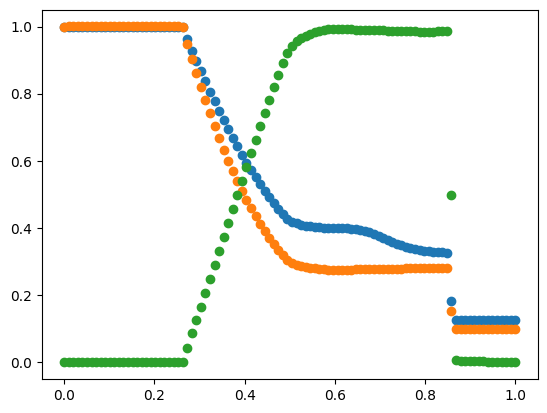

In [24]:
# first 15000step non-conservation
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()


In [147]:
new_array = np.array(u_pred[:,2])
#new_array = np.array(x)
file = open("p.txt", "w+")
content = str(new_array)
file.write(content)
file.close()


In [ ]:
# first 15000step conservation
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()

In [ ]:
# first 15000step non-conservation
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()

In [ ]:
#np.size(id_f)
x_int_train = np.hstack((t_int, x_int))    # Random (x,t) - vectorized
#np.size(x_int_train)
#np.size(x_int)
#np.size(t_int)

In [ ]:
def NewPoint(x,t):
    xl = -0.2
    xr = 1.8
    dgt = 0.0
    dg1 = np.array([])
    M = np.array([])
    N = np.size(x)
    L = np.array([])
    y = np.copy(x)
    for i in range(N):
        if i == 0:
            L = np.append(L,x[0]-xl)
            dgl = dg(x[0],t)
            dgr = dg(xl,t)
            dga = 0.5*(np.abs(dgl)+np.abs(dgr))
            dg1= np.append(dg1,dga)
            dgt += dga*L[i]
        elif i < N-1:
            L = np.append(L,x[i+1]-x[i])
            dgl = dg(x[i],t)
            dgr = dg(x[i+1],t)
            dga = 0.5*(np.abs(dgl)+np.abs(dgr))
            dg1= np.append(dg1,dga)
            dgt += dga*L[i]
        else:
            L = np.append(L,xr-x[N-1])
            dgl = dg(x[N-1],t)
            dgr = dg(xr,t)
            dga = 0.5*(np.abs(dgl)+np.abs(dgr))
            dg1= np.append(dg1,dga)
            dgt += dga*L[N-1]
    for i in range(N):
        M = np.append(M,int((dg1[i]*L[i])/dgt*N+0.5))

    print("M")
  #  print(M)
  #  print("L")
  #  print(L)
    print("dg1")
    print(dg1)
    Mt = 0

    for i in range(N):
        if i ==0 and M[0] > 0:
            for j in range(int(M[0])):
                y[j] = (x[0] - xl)/M[0]*(j+1) + xl
        elif i < N-1 and M[i]> 0 and Mt<N:
            for j in range(int(M[i])):
                y[j+Mt] = (x[i] - x[i-1])/M[i]*(j+1) + x[i-1]
        elif i==N-1 and M[N-1] >0:
            for j in range(int(M[N-1])):
                y[j+Mt] = (xr - x[N-1])/M[N-1]*(j+1) + x[N-1]
        
        Mt = Mt + int(M[i])
    return dg1



In [ ]:
x = np.linspace(-0.2, 1.8, 100)                                   # Partitioned spatial axis
t = np.linspace(0, 0.2, 100)                                   # Partitioned spatial axis

In [ ]:
x_r = np.empty(10000, dtype=np.float32)
t_r = np.empty(10000, dtype=np.float32)
i=0
for i in range(np.size(t)):
    x_r[i*100:99+i*100] =NewPoint(x[0:99],t[99])
    t_r[i*100:99+i*100] =t[i]

In [ ]:
x_r[600:699]

In [ ]:
plt.scatter(x[0:99],x_r[0:99])

In [ ]:
x_r = np.empty(10000, dtype=np.float32)
t_r = np.empty(10000, dtype=np.float32)
for i in range(np.size(t)):
    x_r[i*100:99+i*100] =NewPoint(x_r[i*100:99+i*100],t[i])
    #t_r[i*100:99+i*100] =t[i]

In [ ]:
t[0]

In [ ]:
T = t_r.flatten()[:, None]                                         # Vectorized t_grid
X = x_r.flatten()[:, None]                                         # Vectorized x_grid
x_test = np.hstack((T, X))                                            # Vectorized whole domain

In [ ]:

y =NewPoint(x,t[1])

In [ ]:
dg(1.8,0.2)

In [ ]:
def dg(x,t):
    y_t=np.array([[x]])
    t_t=np.array([[t]])
    x_t = np.hstack((y_t,t_t))

    x_t = torch.tensor(x_t, requires_grad=True, dtype=torch.float32).to(device)
    loss = model.loss_pde(x_t)                                    # Loss function of PDE
    y = model.net(x_t)                                                # Neural network
    rho,p,u = y[:, 0:1], y[:, 1:2], y[:, 2:]                       # NN_{rho}, NN_{u}, NN_{p}
    drho_g = gradients(rho, x_t)[0]
    d = torch.tensor(drho_g, dtype=torch.float32).to(device1)
    return d.numpy()[0][0]


In [ ]:
x = np.linspace(-0.2, 1.8, 1000)                                   # Partitioned spatial axis
t = np.linspace(0.2, 0.2, 1)                                        # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)                                    # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]                                        # Vectorized t_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
x_test = np.hstack((T, X))                                            # Vectorized whole domain
x_test1 = torch.tensor(x_test, dtype=torch.float32).to(device)
u_pred1 = to_numpy(model(x_test1))

In [ ]:

plt.plot(x[:],u_pred[:,0])

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x[:],u_pred[:,0])
plt.plot(x[:],u_pred[:,1])
plt.plot(x[:],u_pred[:,2])

In [ ]:
y = model.net(x_int_train)                                                # Neural network
rho,p,u = y[:, 0:1], y[:, 1:2], y[:, 2:]                       # NN_{rho}, NN_{u}, NN_{p}
drho_g = gradients(rho, x_int_train)[0]

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x,u_pred[:,0])
plt.plot(x[:],u_pred[:,1])
plt.plot(x[:],u_pred[:,2])

In [58]:
#device1 = torch.device('cpu')                                          # Run on CPU
torch.save(model,'1.pt')

In [ ]:
device = torch.device("cuda")
#model.load_state_dict(torch.load(PATH))
model.to(device)

# 文件读取模型

In [148]:
torch.save(model,'1.pt')


In [62]:
model = torch.load('1.pt')

In [ ]:

import matplotlib.pyplot as plt
x = np.linspace(-8.0 / 28.0, 20.0 / 28.0, num_x)  # Partitioned spatial axis
t = np.linspace(2.0, 2.0, 1)  # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)  # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]  # Vectorized t_grid
X = x_grid.flatten()[:, None]  # Vectorized x_grid
x_test = np.hstack((T, X))                                            # Vectorized whole domain
x_test = torch.tensor(x_test, dtype=torch.float32).to('cpu')
u_pred = to_numpy(model(x_test))
plt.plot(x,u_pred[:,0])
plt.plot(x,u_pred[:,1])
plt.plot(x,u_pred[:,2])
plt.plot(x,u_pred[:,3])
plt.plot(x,u_pred[:,4])

In [ ]:

plt.plot(x,u_pred[:,4])

In [ ]:
#u_pred[:,0]
import matplotlib.pyplot as plt
plt.plot(x[300:700],u_pred[300:700,0])
plt.plot(x[300:700],u_pred[300:700,1])
plt.plot(x[300:700],u_pred[300:700,2])

In [ ]:
x = np.linspace(-1.5, 3.125, num_x)                                   # Partitioned spatial axis
t = np.linspace(0.2, 0.2, 1)                                        # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)                                    # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]                                         # Vectorized t_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
x_test = np.hstack((T, X))                                            # Vectorized whole domain
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
u_pred = to_numpy(model(x_test))

import matplotlib.pyplot as plt
plt.plot(x[300:700],u_pred[300:700,0])
plt.plot(x[300:700],u_pred[300:700,1])
plt.plot(x[300:700],u_pred[300:700,2])

In [ ]:
def fun(x):
    return x.mean()

fun([1,2,3,4;1,2,3,4])

In [ ]:
(1,2,3,4).mean()

In [ ]:
p = np.zeros(100)

In [ ]:
p.mean()